# 🔤 Thai Character Recognition - Transfer Learning
## โมเดลตรวจจับอักษรไทยและเลขไทย

**เปรียบเทียบ 3 โมเดล:**
1. ResNet50
2. EfficientNet-B3
3. MobileNetV3-Large

**Features:**
- Data Augmentation with Preview
- Transfer Learning
- Performance Comparison
- Confusion Matrix & Classification Report

In [1]:
DATA_PATH = 'Data_text'

In [2]:
# โหลด Libraries ที่จำเป็น
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import json
import time
import copy
from tqdm import tqdm
import os
import warnings
warnings.filterwarnings('ignore')

print("✅ โหลด Libraries สำเร็จ")
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA Device: {torch.cuda.get_device_name(0)}")

✅ โหลด Libraries สำเร็จ
PyTorch Version: 2.4.1+cu124
CUDA Available: True
CUDA Device: NVIDIA GeForce RTX 4070


## 🎨 ตั้งค่าฟอนต์สำหรับภาษาไทย
กำหนดฟอนต์เพื่อแสดงผลภาษาไทยในกราฟ

In [3]:
# ตั้งค่าฟอนต์สำหรับภาษาไทยใน matplotlib
import matplotlib.font_manager as fm
from matplotlib import rcParams

def setup_thai_font():
    """
    ตั้งค่าฟอนต์สำหรับแสดงภาษาไทยใน matplotlib
    """
    # ฟอนต์ที่รองรับภาษาไทยใน Windows
    thai_fonts = [
        'Tahoma',           # มีใน Windows ทุกเวอร์ชัน
        'Angsana New',      # ฟอนต์ไทยมาตรฐาน
        'Cordia New',       # ฟอนต์ไทยมาตรฐาน
        'Browallia New',    # ฟอนต์ไทยมาตรฐาน
        'TH SarabunPSK',    # ฟอนต์ไทย PSK
        'Leelawadee UI',    # ฟอนต์ใน Windows 10/11
    ]
    
    # หาฟอนต์ที่มีในระบบ
    available_fonts = [f.name for f in fm.fontManager.ttflist]
    
    # เลือกฟอนต์แรกที่พบ
    selected_font = None
    for font in thai_fonts:
        if font in available_fonts:
            selected_font = font
            break
    
    # ถ้าไม่พบฟอนต์ไทย ใช้ DejaVu Sans (รองรับ Unicode)
    if selected_font is None:
        selected_font = 'DejaVu Sans'
        print("⚠️ ไม่พบฟอนต์ไทย ใช้ DejaVu Sans (อาจแสดงผลภาษาไทยไม่สมบูรณ์)")
    else:
        print(f"✅ ใช้ฟอนต์: {selected_font}")
    
    # ตั้งค่า matplotlib
    rcParams['font.family'] = selected_font
    rcParams['font.sans-serif'] = [selected_font] + rcParams['font.sans-serif']
    rcParams['axes.unicode_minus'] = False  # แก้ปัญหาเครื่องหมายลบ
    
    return selected_font

# ตั้งค่าฟอนต์
thai_font = setup_thai_font()

print(f"📝 ฟอนต์ที่ใช้: {thai_font}")
print("✅ ตั้งค่าฟอนต์ภาษาไทยสำเร็จ")
print("💡 กราฟทั้งหมดจะแสดงผลภาษาไทยได้แล้ว")

✅ ใช้ฟอนต์: Tahoma
📝 ฟอนต์ที่ใช้: Tahoma
✅ ตั้งค่าฟอนต์ภาษาไทยสำเร็จ
💡 กราฟทั้งหมดจะแสดงผลภาษาไทยได้แล้ว


## 📌 Configuration & Settings

In [4]:
# ตั้งค่าพารามิเตอร์
DATA_PATH = "Data_text"  

BATCH_SIZE = 32
NUM_EPOCHS = 20
LEARNING_RATE = 0.001
IMG_SIZE = 224

# สร้างโฟลเดอร์สำหรับเก็บผลลัพธ์
OUTPUT_DIRS = {
    'resnet50': 'outputs_resnet50',
    'efficientnet_b3': 'outputs_efficientnet_b3',
    'mobilenet_v3': 'outputs_mobilenet_v3'
}

for dir_name in OUTPUT_DIRS.values():
    os.makedirs(dir_name, exist_ok=True)
    os.makedirs(os.path.join(dir_name, 'misclassified'), exist_ok=True)

print(f"📁 Data Path: {DATA_PATH}")
print(f"🔢 Batch Size: {BATCH_SIZE}")
print(f"🔁 Epochs: {NUM_EPOCHS}")
print(f"📏 Image Size: {IMG_SIZE}x{IMG_SIZE}")
print(f"✅ Output directories created")

📁 Data Path: Data_text
🔢 Batch Size: 32
🔁 Epochs: 20
📏 Image Size: 224x224
✅ Output directories created


## 🎨 Data Augmentation with Preview
ดูภาพตัวอย่างของข้อมูลที่ถูก Augment

In [5]:
print(f"✅ กำหนดค่า IMG_SIZE = {IMG_SIZE}")
print(f"✅ กำหนดค่า BATCH_SIZE = {BATCH_SIZE}")
print(f"✅ กำหนดค่า DATA_PATH = {DATA_PATH}")

# 🟢 Gentle Transforms - สำหรับอักษรที่ละเอียดและซับซ้อน
gentle_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Pad(10, fill=255),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(5, fill=255),  # หัน ±5 องศา
    transforms.ToTensor(),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 0.3)),
    transforms.Normalize((0.5,), (0.5,))
])

# 🟡 Mild Transforms - สำหรับอักษรทั่วไป
mild_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Pad(10, fill=255),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(10, fill=255),     # หัน ±10 องศา
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.9, 1.1), fill=255),
    transforms.ToTensor(),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.3, 0.7)),
    transforms.Normalize((0.5,), (0.5,))
])

# 🔴 Strong Transforms - สำหรับอักษรที่ทนทานต่อการเปลี่ยนแปลง
strong_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Pad(12, fill=255),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(20, fill=255),           # หัน ±20 องศา
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.85, 1.15), shear=5, fill=255),
    transforms.RandomPerspective(distortion_scale=0.1, p=0.5, fill=255),
    transforms.ToTensor(),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.7, 1.0)),
    transforms.Normalize((0.5,), (0.5,))
])

# 📝 สำหรับ Validation และ Test (ไม่ Augment)
val_test_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Pad(10, fill=255),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 👁️ สำหรับ Preview (ไม่ Normalize เพื่อแสดงผล)
preview_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Pad(10, fill=255),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(10, fill=255),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.9, 1.1), fill=255),
    transforms.RandomPerspective(distortion_scale=0.1, p=0.5, fill=255),
])

# ============================================================================
# 🚀 Triple Augmentation Dataset - ทุกรูปได้ Augment ทั้ง 3 ระดับ
# ============================================================================

class TripleAugmentDataset(torch.utils.data.Dataset):
    """
    Dataset ที่สร้าง augmented images ทั้ง 3 ระดับสำหรับทุกรูป
    แต่ละ original image จะกลายเป็น 3 augmented images
    """
    def __init__(self, base_dataset, indices, class_names, mode='train'):
        self.base_dataset = base_dataset
        self.indices = list(indices)
        self.class_names = class_names
        self.mode = mode
        
        # สำหรับ training จะใช้ triple augmentation
        # สำหรับ val/test ใช้ transform ธรรมดา
        if mode == 'train':
            # แต่ละรูปจะมี 3 เวอร์ชัน (gentle, mild, strong)
            self.augment_types = ['gentle', 'mild', 'strong']
            self.total_length = len(self.indices) * 3
        else:
            self.total_length = len(self.indices)
        
    def __len__(self):
        return self.total_length
        
    def __getitem__(self, idx):
        if self.mode == 'train':
            # คำนวณ original image index และ augmentation type
            original_idx_in_list = idx // 3  # ภาพต้นฉบับที่ไหน
            augment_type_idx = idx % 3       # augmentation แบบไหน (0=gentle, 1=mild, 2=strong)
            
            actual_idx = self.indices[original_idx_in_list]
            image, label = self.base_dataset[actual_idx]
            
            # เลือก augmentation ตาม type
            if augment_type_idx == 0:
                # Gentle Augmentation
                image = gentle_transforms(image)
            elif augment_type_idx == 1:
                # Mild Augmentation
                image = mild_transforms(image)
            else:
                # Strong Augmentation
                image = strong_transforms(image)
                
        else:
            # สำหรับ val/test - ไม่ augment
            actual_idx = self.indices[idx]
            image, label = self.base_dataset[actual_idx]
            image = val_test_transforms(image)
            
        return image, label

print("✅ สร้าง Triple Augmentation Dataset สำเร็จ")
print("📝 Triple Augmentation Features:")
print("  🟢 Gentle: ทุกรูปจะได้ Rotation ±5°, GaussianBlur อ่อน")
print("  🟡 Mild: ทุกรูปจะได้ Rotation ±10°, Affine, GaussianBlur ปานกลาง") 
print("  🔴 Strong: ทุกรูปจะได้ Rotation ±20°, Affine, Perspective, Shear, GaussianBlur แข็ง")
print("  📈 Result: Dataset ขยายเป็น 3 เท่า (แต่ละรูปกลายเป็น 3 รูป)")
print("  ⚡ Training: ครบทุกระดับ augmentation สำหรับทุกรูป")

✅ กำหนดค่า IMG_SIZE = 224
✅ กำหนดค่า BATCH_SIZE = 32
✅ กำหนดค่า DATA_PATH = Data_text
✅ สร้าง Triple Augmentation Dataset สำเร็จ
📝 Triple Augmentation Features:
  🟢 Gentle: ทุกรูปจะได้ Rotation ±5°, GaussianBlur อ่อน
  🟡 Mild: ทุกรูปจะได้ Rotation ±10°, Affine, GaussianBlur ปานกลาง
  🔴 Strong: ทุกรูปจะได้ Rotation ±20°, Affine, Perspective, Shear, GaussianBlur แข็ง
  📈 Result: Dataset ขยายเป็น 3 เท่า (แต่ละรูปกลายเป็น 3 รูป)
  ⚡ Training: ครบทุกระดับ augmentation สำหรับทุกรูป


## 📊 Load Dataset & DataLoader

In [6]:
# ============================================================================
# 📊 โหลดและเตรียม Dataset แบบครบวงจร (ลดความซ้ำซ้อน)
# ============================================================================

def load_and_prepare_dataset():
    """
    โหลดและเตรียม dataset พร้อม train/val/test splits ในฟังก์ชันเดียว
    """
    try:
        print("🔄 เริ่มโหลดและเตรียม Dataset...")
        
        # โหลด base dataset
        base_dataset = datasets.ImageFolder(root=DATA_PATH, allow_empty=True)
        
        if len(base_dataset) == 0:
            raise ValueError(f"ไม่พบรูปภาพในโฟลเดอร์ {DATA_PATH}!")
        
        # ข้อมูลพื้นฐาน
        num_classes = len(base_dataset.classes)
        class_names = base_dataset.classes
        class_to_idx = base_dataset.class_to_idx
        
        print(f"✅ โหลด Dataset สำเร็จ")
        print(f"📊 จำนวนคลาส: {num_classes}")
        print(f"📊 จำนวนรูปภาพทั้งหมด: {len(base_dataset)}")
        print(f"📝 ตัวอย่างคลาส (10 คลาสแรก): {class_names[:10]}")
        
        # วิเคราะห์ประเภทอักษรแบบง่าย (ใช้การนับพื้นฐาน)
        char_type_counts = {
            'numbers': 0, 'vowels': 0, 'consonants': 0, 
            'tone_marks': 0, 'special': 0
        }
        
        # การจำแนกประเภทอักษรไทยแบบพื้นฐาน
        for class_name in class_names:
            if class_name in ['๐', '๑', '๒', '๓', '๔', '๕', '๖', '๗', '๘', '๙']:
                char_type_counts['numbers'] += 1
            elif class_name in ['อะ', 'อา', 'อิ', 'อี', 'อึ', 'อือ', 'อุ', 'อู', 'เอ', 'แอ', 'โอ', 'ใอ', 'ไอ']:
                char_type_counts['vowels'] += 1
            elif class_name.startswith('ไม้'):
                char_type_counts['tone_marks'] += 1
            elif class_name in ['การันต์', 'ฯ', 'ๅ']:
                char_type_counts['special'] += 1
            else:
                char_type_counts['consonants'] += 1
        
        print(f"\n🔍 การวิเคราะห์ประเภทอักษร:")
        for char_type, count in char_type_counts.items():
            if count > 0:
                print(f"  {char_type}: {count} คลาส")
        
        # แบ่งข้อมูล Train:Val:Test = 80:10:10
        train_size = int(0.8 * len(base_dataset))
        val_size = int(0.1 * len(base_dataset))
        test_size = len(base_dataset) - train_size - val_size
        
        train_indices, val_indices, test_indices = random_split(
            range(len(base_dataset)),
            [train_size, val_size, test_size],
            generator=torch.Generator().manual_seed(42)
        )
        
        print(f"\n📦 แบ่งข้อมูลสำเร็จ:")
        print(f"  - Train: {train_size} รูป ({train_size/len(base_dataset)*100:.1f}%)")
        print(f"  - Validation: {val_size} รูป ({val_size/len(base_dataset)*100:.1f}%)")
        print(f"  - Test: {test_size} รูป ({test_size/len(base_dataset)*100:.1f}%)")
        
        return {
            'base_dataset': base_dataset,
            'num_classes': num_classes,
            'class_names': class_names,
            'class_to_idx': class_to_idx,
            'char_type_counts': char_type_counts,
            'train_indices': train_indices,
            'val_indices': val_indices, 
            'test_indices': test_indices,
            'train_size': train_size,
            'val_size': val_size,
            'test_size': test_size
        }
        
    except Exception as e:
        print(f"❌ เกิดข้อผิดพลาด: {e}")
        print(f"กรุณาตรวจสอบว่าโฟลเดอร์ '{DATA_PATH}' มีอยู่และมีโครงสร้างที่ถูกต้อง")
        return None

def create_datasets_and_loaders(dataset_info, augmentation_mode='triple'):
    """
    สร้าง datasets และ dataloaders จากข้อมูลที่เตรียมไว้แล้ว
    """
    if dataset_info is None:
        print("❌ ไม่สามารถสร้าง datasets ได้ เนื่องจากข้อมูลไม่พร้อม")
        return None
    
    print(f"🔄 สร้าง {augmentation_mode.title()} Augmentation Datasets...")
    
    try:
        if augmentation_mode == 'triple':
            # ใช้ Triple Augmentation
            train_dataset = TripleAugmentDataset(
                dataset_info['base_dataset'], 
                dataset_info['train_indices'].indices, 
                dataset_info['class_names'], 
                mode='train'
            )
            val_dataset = TripleAugmentDataset(
                dataset_info['base_dataset'], 
                dataset_info['val_indices'].indices, 
                dataset_info['class_names'], 
                mode='val'
            )
            test_dataset = TripleAugmentDataset(
                dataset_info['base_dataset'], 
                dataset_info['test_indices'].indices, 
                dataset_info['class_names'], 
                mode='test'
            )
            augment_info = "Triple Augmentation (3x dataset size)"
            
        else:
            return
        
        # สร้าง DataLoaders
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
        test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
        
        print(f"✅ สร้าง Datasets และ DataLoaders สำเร็จ")
        print(f"🧠 {augment_info}")
        print(f"  ✓ Training: {len(train_dataset)} samples")
        print(f"  ✓ Validation: {len(val_dataset)} samples") 
        print(f"  ✓ Test: {len(test_dataset)} samples")
        
        return {
            'train_dataset': train_dataset,
            'val_dataset': val_dataset, 
            'test_dataset': test_dataset,
            'train_loader': train_loader,
            'val_loader': val_loader,
            'test_loader': test_loader,
            'augmentation_mode': augmentation_mode
        }
        
    except Exception as e:
        print(f"❌ เกิดข้อผิดพลาดในการสร้าง datasets: {e}")
        return None

# โหลดและเตรียมข้อมูลพื้นฐาน
dataset_info = load_and_prepare_dataset()

# สร้าง Triple Augmentation datasets และ loaders (default)
loaders_info = create_datasets_and_loaders(dataset_info, 'triple')

if loaders_info:
    # กำหนดตัวแปรให้พร้อมใช้งาน
    base_dataset = dataset_info['base_dataset']
    num_classes = dataset_info['num_classes']
    class_names = dataset_info['class_names']
    class_to_idx = dataset_info['class_to_idx']
    char_type_counts = dataset_info['char_type_counts']
    train_indices = dataset_info['train_indices']
    val_indices = dataset_info['val_indices']
    test_indices = dataset_info['test_indices']
    train_size = dataset_info['train_size']
    val_size = dataset_info['val_size']
    test_size = dataset_info['test_size']
    
    train_dataset = loaders_info['train_dataset']
    val_dataset = loaders_info['val_dataset']
    test_dataset = loaders_info['test_dataset']
    train_loader = loaders_info['train_loader']
    val_loader = loaders_info['val_loader']
    test_loader = loaders_info['test_loader']
    
    print(f"\n🎯 ระบบพร้อมใช้งาน! ใช้ augmentation_mode = '{loaders_info['augmentation_mode']}'")
    print(f"💡 เปลี่ยน mode: loaders_info = create_datasets_and_loaders(dataset_info, 'smart')")
else:
    print("❌ ไม่สามารถเตรียม datasets ได้")

🔄 เริ่มโหลดและเตรียม Dataset...
✅ โหลด Dataset สำเร็จ
📊 จำนวนคลาส: 72
📊 จำนวนรูปภาพทั้งหมด: 80548
📝 ตัวอย่างคลาส (10 คลาสแรก): ['ก', 'การันต์', 'ข', 'ฃ', 'ค', 'ง', 'จ', 'ฉ', 'ช', 'ซ']

🔍 การวิเคราะห์ประเภทอักษร:
  numbers: 10 คลาส
  vowels: 12 คลาส
  consonants: 41 คลาส
  tone_marks: 6 คลาส
  special: 3 คลาส

📦 แบ่งข้อมูลสำเร็จ:
  - Train: 64438 รูป (80.0%)
  - Validation: 8054 รูป (10.0%)
  - Test: 8056 รูป (10.0%)
🔄 สร้าง Triple Augmentation Datasets...
✅ สร้าง Datasets และ DataLoaders สำเร็จ
🧠 Triple Augmentation (3x dataset size)
  ✓ Training: 193314 samples
  ✓ Validation: 8054 samples
  ✓ Test: 8056 samples

🎯 ระบบพร้อมใช้งาน! ใช้ augmentation_mode = 'triple'
💡 เปลี่ยน mode: loaders_info = create_datasets_and_loaders(dataset_info, 'smart')


## 👀 แสดงตัวอย่าง Augmented Training Data
ดูภาพต้นฉบับและภาพที่ผ่าน Triple Augmentation แล้ว

🚀 เริ่มแสดงตัวอย่าง Augmented Training Data...

🔍 แสดงตัวอย่าง Augmented Training Data


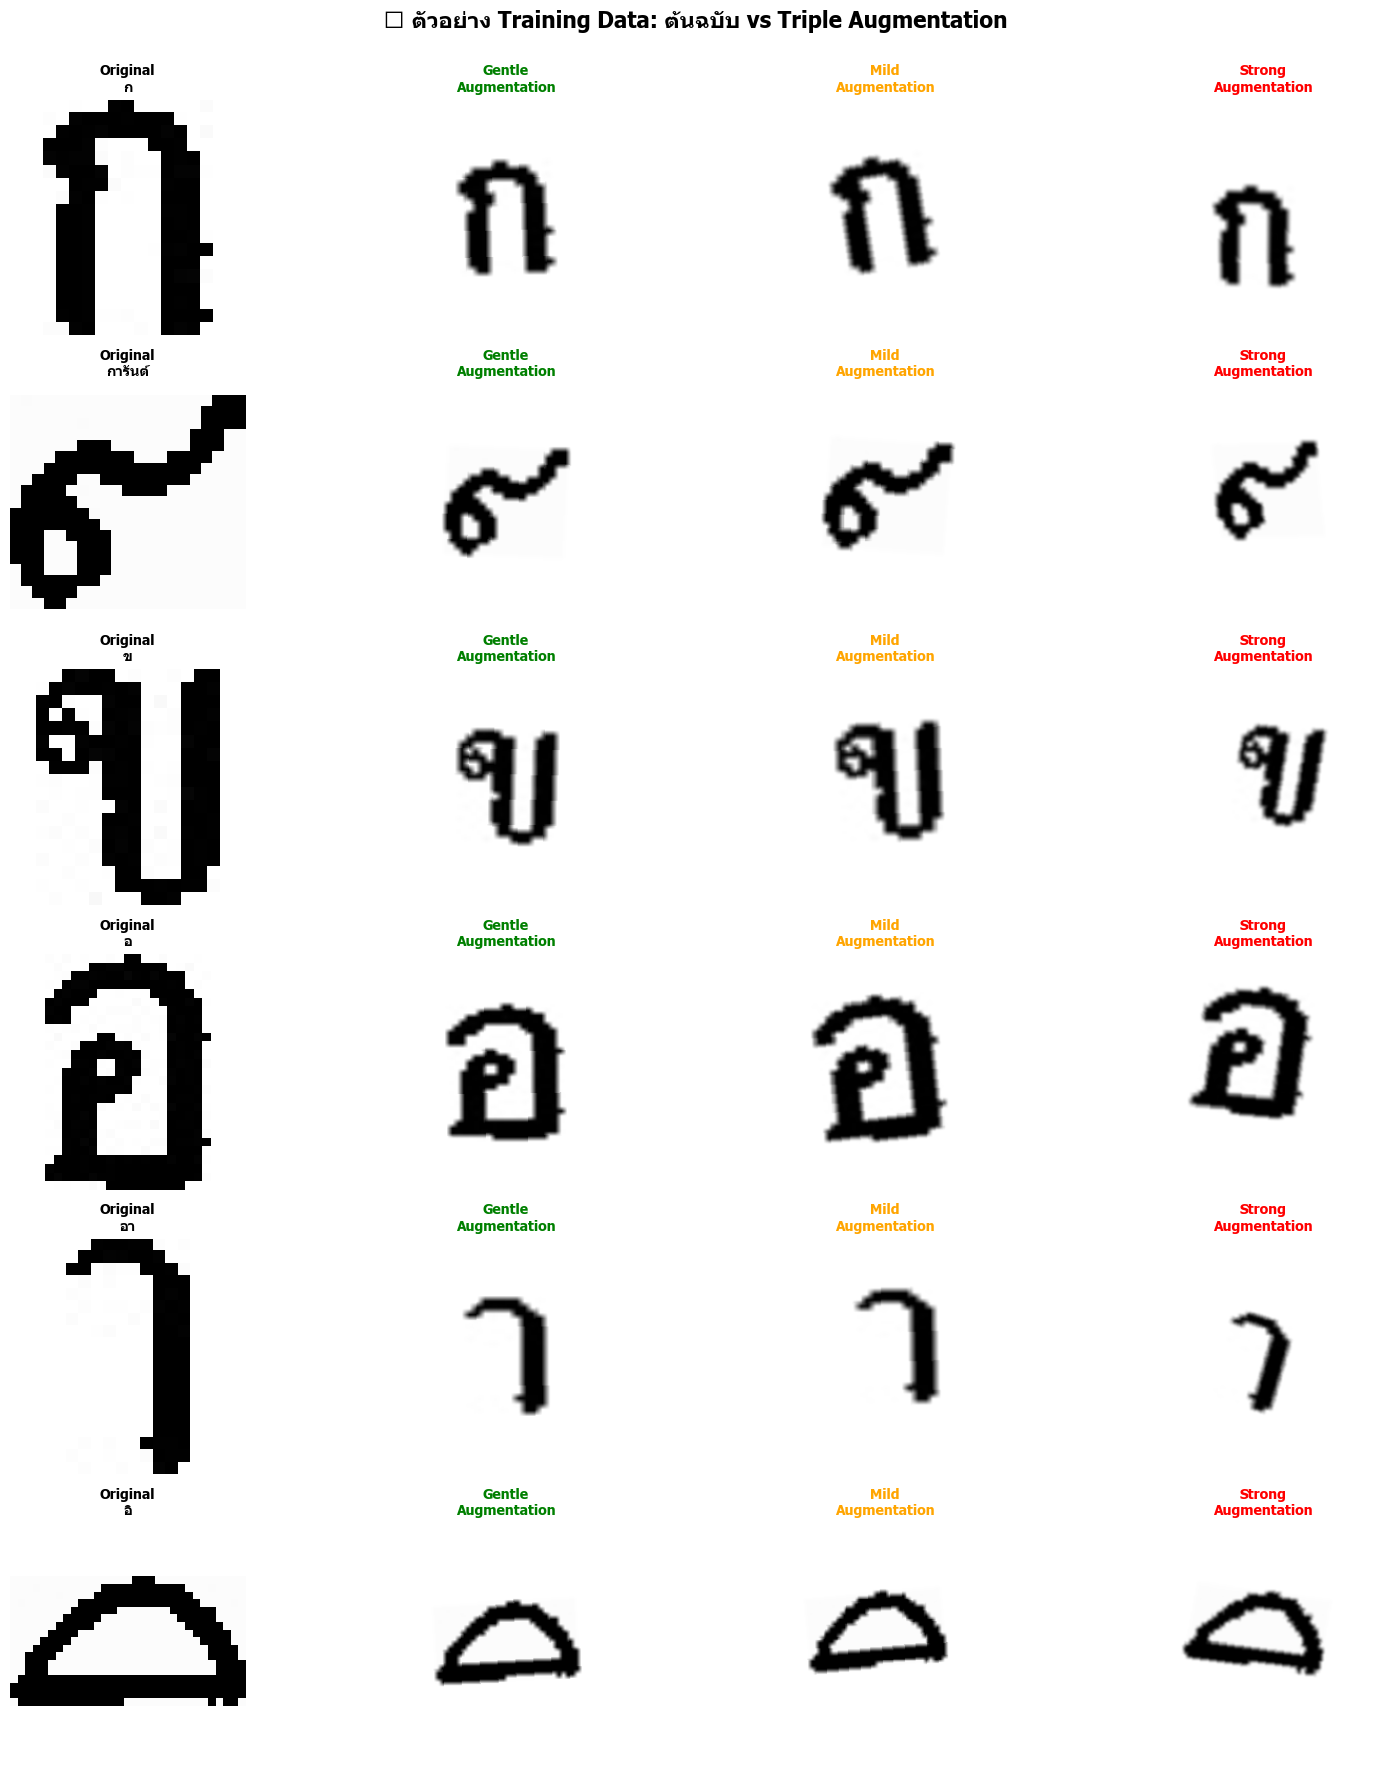


📊 ข้อมูล Training Dataset:
  - Original images: 64438 รูป
  - After Triple Augmentation: 193314 รูป (3x)
  - Augmentation types: Gentle, Mild, Strong
  - แต่ละภาพต้นฉบับจะกลายเป็น 3 เวอร์ชัน


In [7]:
# แสดงตัวอย่างข้อมูลจาก Augmented Training Dataset

def show_augmented_samples(train_dataset, base_dataset, train_indices, num_samples=9, classes_to_show=None):
    """
    แสดงตัวอย่างภาพต้นฉบับและภาพที่ผ่าน Triple Augmentation
    """
    print("🔍 แสดงตัวอย่าง Augmented Training Data")
    print("="*60)
    
    # ถ้าไม่ระบุคลาสที่ต้องการดู จะสุ่มเลือก
    if classes_to_show is None:
        import random
        classes_to_show = random.sample(range(len(class_names)), min(num_samples, len(class_names)))
    
    # คำนวณ layout
    cols = 4  # Original + 3 augmented versions
    rows = len(classes_to_show)
    
    fig, axes = plt.subplots(rows, cols, figsize=(16, rows * 3))
    fig.suptitle('👀 ตัวอย่าง Training Data: ต้นฉบับ vs Triple Augmentation', 
                 fontsize=16, weight='bold', y=0.98)
    
    # ถ้ามีแค่ 1 แถว ต้องแปลง axes ให้เป็น 2D array
    if rows == 1:
        axes = axes.reshape(1, -1)
    
    for row, class_idx in enumerate(classes_to_show):
        class_name = class_names[class_idx]
        
        # หาภาพต้นฉบับจากคลาสนี้
        original_idx = None
        for idx in train_indices.indices:
            if base_dataset[idx][1] == class_idx:
                original_idx = idx
                break
        
        if original_idx is None:
            print(f"⚠️ ไม่พบภาพจากคลาส '{class_name}' ใน training set")
            continue
            
        # โหลดภาพต้นฉบับ
        original_image, label = base_dataset[original_idx]
        
        # แสดงภาพต้นฉบับ (ไม่ผ่าน transform)
        if original_image.mode != 'L':
            original_image = original_image.convert('L')
        
        axes[row, 0].imshow(original_image, cmap='gray')
        axes[row, 0].set_title(f'Original\n{class_name}', fontsize=10, weight='bold')
        axes[row, 0].axis('off')
        
        # สร้างภาพที่ผ่าน augmentation ทั้ง 3 แบบ
        augment_types = ['Gentle', 'Mild', 'Strong']
        transforms_list = [gentle_transforms, mild_transforms, strong_transforms]
        colors = ['green', 'orange', 'red']
        
        for col, (aug_type, transform, color) in enumerate(zip(augment_types, transforms_list, colors), 1):
            # ใช้ transform กับภาพต้นฉบับ
            augmented_image = transform(original_image)
            
            # Denormalize เพื่อแสดงผล (กลับจาก [-1,1] เป็น [0,1])
            if isinstance(augmented_image, torch.Tensor):
                img_np = augmented_image.squeeze().cpu().numpy()
                img_np = (img_np * 0.5) + 0.5  # Denormalize
                img_np = np.clip(img_np, 0, 1)
            else:
                img_np = np.array(augmented_image)
            
            axes[row, col].imshow(img_np, cmap='gray')
            axes[row, col].set_title(f'{aug_type}\nAugmentation', 
                                   fontsize=10, weight='bold', color=color)
            axes[row, col].axis('off')
            
            # เพิ่มกรอบสี
            for spine in axes[row, col].spines.values():
                spine.set_edgecolor(color)
                spine.set_linewidth(2)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.show()
    
    print(f"\n📊 ข้อมูล Training Dataset:")
    print(f"  - Original images: {len(train_indices)} รูป")
    print(f"  - After Triple Augmentation: {len(train_dataset)} รูป (3x)")
    print(f"  - Augmentation types: Gentle, Mild, Strong")
    print(f"  - แต่ละภาพต้นฉบับจะกลายเป็น 3 เวอร์ชัน")

def analyze_dataset_distribution():
    """
    วิเคราะห์การกระจายของข้อมูลใน dataset
    """
    print(f"\n📈 วิเคราะห์การกระจายข้อมูล")
    print("="*50)
    
    # นับจำนวนภาพต่อคลาส
    class_counts = {}
    for idx in train_indices.indices:
        _, label = base_dataset[idx]
        class_name = class_names[label]
        class_counts[class_name] = class_counts.get(class_name, 0) + 1
    
    # เรียงตามจำนวนจากมากไปน้อย
    sorted_counts = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)
    
    print(f"Top 10 คลาสที่มีข้อมูลมากที่สุด:")
    for i, (class_name, count) in enumerate(sorted_counts[:10], 1):
        augmented_count = count * 3  # หลัง augmentation
        print(f"  {i:2d}. '{class_name}': {count:4d} รูป → {augmented_count:5d} รูป (หลัง aug)")
    
    print(f"\nTop 5 คลาสที่มีข้อมูลน้อยที่สุด:")
    for i, (class_name, count) in enumerate(sorted_counts[-5:], 1):
        augmented_count = count * 3
        print(f"  {i:2d}. '{class_name}': {count:4d} รูป → {augmented_count:5d} รูป (หลัง aug)")
    
    # สถิติการกระจาย
    counts_only = [count for _, count in sorted_counts]
    print(f"\n📊 สถิติการกระจาย:")
    print(f"  - ค่าเฉลี่ย: {np.mean(counts_only):.1f} รูป/คลาส")
    print(f"  - ค่ามัธยฐาน: {np.median(counts_only):.1f} รูป/คลาส") 
    print(f"  - ค่ามากสุด: {np.max(counts_only)} รูป/คลาส")
    print(f"  - ค่าน้อยสุด: {np.min(counts_only)} รูป/คลาส")
    print(f"  - ส่วนเบี่ยงเบนมาตรฐาน: {np.std(counts_only):.1f}")

# แสดงตัวอย่าง augmented data
print("🚀 เริ่มแสดงตัวอย่าง Augmented Training Data...\n")

# เลือกคลาสที่น่าสนใจเพื่อแสดง (ผสมระหว่างอักษร ตัวเลข และเครื่องหมาย)
interesting_classes = []
for i, class_name in enumerate(class_names):
    if class_name in ['ก', 'ข', 'อ', '๐', '๑', 'อา', 'อิ', 'ไม้เอก', 'การันต์']:
        interesting_classes.append(i)
        if len(interesting_classes) >= 6:  # แสดง 6 คลาส
            break

show_augmented_samples(train_dataset, base_dataset, train_indices, 
                      classes_to_show=interesting_classes)



## 🏗️ Create Models - Transfer Learning
สร้าง 3 โมเดล: ResNet50, EfficientNet-B3, MobileNetV3

In [8]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def create_model(model_name, num_classes, pretrained=True):
    """
    สร้างโมเดล Transfer Learning
    """
    if model_name == 'resnet50':
        model = models.resnet50(pretrained=pretrained)
        # แก้ไข Conv Layer แรกให้รับ 1 channel
        model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)

    elif model_name == 'efficientnet_b3':
        model = models.efficientnet_b3(pretrained=pretrained)
        # แก้ไข Conv Layer แรกให้รับ 1 channel
        model.features[0][0] = nn.Conv2d(1, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, num_classes)

    elif model_name == 'mobilenet_v3':
        model = models.mobilenet_v3_large(pretrained=pretrained)
        # แก้ไข Conv Layer แรกให้รับ 1 channel
        model.features[0][0] = nn.Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        num_ftrs = model.classifier[3].in_features
        model.classifier[3] = nn.Linear(num_ftrs, num_classes)

    else:
        raise ValueError(f"Unknown model: {model_name}")

    return model.to(DEVICE)

# สร้างโมเดลทั้ง 3
models_dict = {}
for model_name in ['resnet50', 'efficientnet_b3', 'mobilenet_v3']:
    models_dict[model_name] = create_model(model_name, num_classes, pretrained=True)
    print(f"✅ สร้าง {model_name} สำเร็จ")


✅ สร้าง resnet50 สำเร็จ
✅ สร้าง efficientnet_b3 สำเร็จ
✅ สร้าง mobilenet_v3 สำเร็จ


## 🚀 Training Function

## 💡 คำแนะนำก่อนเริ่มฝึก

**⚠️ การฝึกโมเดล 3 แบบพร้อมกันจะใช้เวลานานมาก (หลายชั่วโมง)**

**ตัวเลือก:**
1. **ฝึกทั้ง 3 โมเดลพร้อมกัน** (รันเซลล์ "Train All Models")
2. **ฝึกทีละโมเดล** (รันเซลล์ "Train Individual Model" ด้านล่าง)

**เคล็ดลับ:**
- ลด `NUM_EPOCHS` จาก 20 เป็น 5-10 สำหรับการทดสอบ
- ใช้ CUDA/GPU จะเร็วกว่ามาก

In [9]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, model_name):
    """
    ฟังก์ชันสำหรับฝึกโมเดล
    """
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }

    for epoch in range(num_epochs):
        print(f'\n{"="*60}')
        print(f'Epoch {epoch+1}/{num_epochs} - {model_name}')
        print(f'{"="*60}')

        # Training Phase
        model.train()
        running_loss = 0.0
        running_corrects = 0

        train_bar = tqdm(train_loader, desc=f'Training')
        for inputs, labels in train_bar:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            optimizer.zero_grad()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            train_bar.set_postfix({'loss': loss.item()})

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc.item())

        print(f'Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f}')

        # Validation Phase
        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0

        with torch.no_grad():
            val_bar = tqdm(val_loader, desc=f'Validation')
            for inputs, labels in val_bar:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * inputs.size(0)
                val_running_corrects += torch.sum(preds == labels.data)

                val_bar.set_postfix({'loss': loss.item()})

        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_epoch_acc = val_running_corrects.double() / len(val_loader.dataset)

        history['val_loss'].append(val_epoch_loss)
        history['val_acc'].append(val_epoch_acc.item())

        print(f'Val Loss: {val_epoch_loss:.4f} | Val Acc: {val_epoch_acc:.4f}')

        # Save best model
        if val_epoch_acc > best_acc:
            best_acc = val_epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            print(f'✅ New best model! Val Acc: {best_acc:.4f}')

    time_elapsed = time.time() - since
    print(f'\n{"="*60}')
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best Val Acc: {best_acc:.4f}')
    print(f'{"="*60}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

print("✅ Training function created")

✅ Training function created


In [10]:
# ฝึกโมเดลเดียว (สำหรับทดสอบหรือฝึกทีละตัว)
# เปลี่ยน model_to_train เป็น 'resnet50', 'efficientnet_b3', หรือ 'mobilenet_v3'

TRAIN_SINGLE_MODEL = True  # เปลี่ยนเป็น True ถ้าต้องการฝึกแค่โมเดลเดียว
model_to_train = 'efficientnet_b3'  # เลือกโมเดลที่ต้องการฝึก

if TRAIN_SINGLE_MODEL:
    print(f"\n{'#'*70}")
    print(f"##  เริ่มฝึกโมเดลเดียว: {model_to_train.upper()}")
    print(f"{'#'*70}\n")

    model = models_dict[model_to_train]
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # ฟังก์ชันสำหรับฝึกโมเดล
    def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, model_name):
        """
        ฟังก์ชันสำหรับฝึกโมเดล
        """
        since = time.time()
        best_model_wts = copy.deepcopy(model.state_dict())
        best_acc = 0.0

        history = {
            'train_loss': [], 'train_acc': [],
            'val_loss': [], 'val_acc': []
        }

        for epoch in range(num_epochs):
            print(f'\n{"="*60}')
            print(f'Epoch {epoch+1}/{num_epochs} - {model_name}')
            print(f'{"="*60}')

            # Training Phase
            model.train()
            running_loss = 0.0
            running_corrects = 0

            train_bar = tqdm(train_loader, desc=f'Training')
            for inputs, labels in train_bar:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                optimizer.zero_grad()

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                loss.backward()
                optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                train_bar.set_postfix({'loss': loss.item()})

            epoch_loss = running_loss / len(train_loader.dataset)
            epoch_acc = running_corrects.double() / len(train_loader.dataset)

            history['train_loss'].append(epoch_loss)
            history['train_acc'].append(epoch_acc.item())

            print(f'Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f}')

            # Validation Phase
            model.eval()
            val_running_loss = 0.0
            val_running_corrects = 0

            with torch.no_grad():
                val_bar = tqdm(val_loader, desc=f'Validation')
                for inputs, labels in val_bar:
                    inputs = inputs.to(DEVICE)
                    labels = labels.to(DEVICE)

                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    val_running_loss += loss.item() * inputs.size(0)
                    val_running_corrects += torch.sum(preds == labels.data)

                    val_bar.set_postfix({'loss': loss.item()})

            val_epoch_loss = val_running_loss / len(val_loader.dataset)
            val_epoch_acc = val_running_corrects.double() / len(val_loader.dataset)

            history['val_loss'].append(val_epoch_loss)
            history['val_acc'].append(val_epoch_acc.item())

            print(f'Val Loss: {val_epoch_loss:.4f} | Val Acc: {val_epoch_acc:.4f}')

            # Save best model
            if val_epoch_acc > best_acc:
                best_acc = val_epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                print(f'✅ New best model! Val Acc: {best_acc:.4f}')

        time_elapsed = time.time() - since
        print(f'\n{"="*60}')
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best Val Acc: {best_acc:.4f}')
        print(f'{"="*60}')

        # Load best model weights
        model.load_state_dict(best_model_wts)
        return model, history

    # ฝึกโมเดล
    trained_model, history = train_model(
        model, train_loader, val_loader,
        criterion, optimizer, NUM_EPOCHS, model_to_train
    )

    # บันทึกโมเดลและผลลัพธ์
    output_dir = OUTPUT_DIRS[model_to_train]
    model_path = os.path.join(output_dir, f'{model_to_train}_best.pt')
    torch.save(trained_model.state_dict(), model_path)

    # บันทึก history
    history_path = os.path.join(output_dir, 'training_history.json')
    with open(history_path, 'w') as f:
        json.dump(history, f, indent=4)

    # บันทึก class mapping
    class_mapping_path = os.path.join(output_dir, 'class_to_idx.json')
    with open(class_mapping_path, 'w', encoding='utf-8') as f:
        json.dump(class_to_idx, f, ensure_ascii=False, indent=4)

    print(f"\n✅ {model_to_train} ฝึกเสร็จสิ้น")
    print(f"💾 บันทึกโมเดลที่: {model_path}")
else:
    print("ℹ️ ตั้งค่า TRAIN_SINGLE_MODEL = True เพื่อฝึกโมเดลเดียว")
    print("ℹ️ หรือรันเซลล์ 'Train All Models' เพื่อฝึกทั้งหมด")


######################################################################
##  เริ่มฝึกโมเดลเดียว: EFFICIENTNET_B3
######################################################################


Epoch 1/20 - efficientnet_b3


Training: 100%|██████████| 6042/6042 [24:48<00:00,  4.06it/s, loss=0.651]   


Train Loss: 0.1619 | Train Acc: 0.9527


Validation: 100%|██████████| 252/252 [01:07<00:00,  3.75it/s, loss=0.277]   


Val Loss: 0.0743 | Val Acc: 0.9757
✅ New best model! Val Acc: 0.9757

Epoch 2/20 - efficientnet_b3


Training: 100%|██████████| 6042/6042 [16:37<00:00,  6.05it/s, loss=0.441]   


Train Loss: 0.0769 | Train Acc: 0.9761


Validation: 100%|██████████| 252/252 [00:13<00:00, 18.63it/s, loss=0.0129]  


Val Loss: 0.0430 | Val Acc: 0.9873
✅ New best model! Val Acc: 0.9873

Epoch 3/20 - efficientnet_b3


Training: 100%|██████████| 6042/6042 [16:37<00:00,  6.06it/s, loss=0.2]     


Train Loss: 0.0602 | Train Acc: 0.9810


Validation: 100%|██████████| 252/252 [00:13<00:00, 18.67it/s, loss=0.0664]  


Val Loss: 0.0376 | Val Acc: 0.9886
✅ New best model! Val Acc: 0.9886

Epoch 4/20 - efficientnet_b3


Training: 100%|██████████| 6042/6042 [16:38<00:00,  6.05it/s, loss=0.0169]  


Train Loss: 0.0518 | Train Acc: 0.9839


Validation: 100%|██████████| 252/252 [00:13<00:00, 18.61it/s, loss=0.0153]  


Val Loss: 0.0414 | Val Acc: 0.9875

Epoch 5/20 - efficientnet_b3


Training: 100%|██████████| 6042/6042 [16:39<00:00,  6.04it/s, loss=0.23]    


Train Loss: 0.0447 | Train Acc: 0.9861


Validation: 100%|██████████| 252/252 [00:13<00:00, 18.32it/s, loss=0.0535]  


Val Loss: 0.0389 | Val Acc: 0.9878

Epoch 6/20 - efficientnet_b3


Training: 100%|██████████| 6042/6042 [16:37<00:00,  6.06it/s, loss=0.00321] 


Train Loss: 0.0405 | Train Acc: 0.9870


Validation: 100%|██████████| 252/252 [00:13<00:00, 18.65it/s, loss=0.00265] 


Val Loss: 0.0359 | Val Acc: 0.9896
✅ New best model! Val Acc: 0.9896

Epoch 7/20 - efficientnet_b3


Training: 100%|██████████| 6042/6042 [16:37<00:00,  6.06it/s, loss=1.37]    


Train Loss: 0.0372 | Train Acc: 0.9882


Validation: 100%|██████████| 252/252 [00:13<00:00, 18.67it/s, loss=0.000453]


Val Loss: 0.0386 | Val Acc: 0.9878

Epoch 8/20 - efficientnet_b3


Training: 100%|██████████| 6042/6042 [16:36<00:00,  6.06it/s, loss=1.06]    


Train Loss: 0.0339 | Train Acc: 0.9890


Validation: 100%|██████████| 252/252 [00:13<00:00, 18.61it/s, loss=0.0175]  


Val Loss: 0.0324 | Val Acc: 0.9907
✅ New best model! Val Acc: 0.9907

Epoch 9/20 - efficientnet_b3


Training: 100%|██████████| 6042/6042 [17:11<00:00,  5.86it/s, loss=0.000702]


Train Loss: 0.0311 | Train Acc: 0.9900


Validation: 100%|██████████| 252/252 [00:14<00:00, 17.93it/s, loss=0.0214]  


Val Loss: 0.0366 | Val Acc: 0.9906

Epoch 10/20 - efficientnet_b3


Training: 100%|██████████| 6042/6042 [18:02<00:00,  5.58it/s, loss=0.0044]  


Train Loss: 0.0297 | Train Acc: 0.9904


Validation: 100%|██████████| 252/252 [00:17<00:00, 14.65it/s, loss=0.00187] 


Val Loss: 0.0378 | Val Acc: 0.9901

Epoch 11/20 - efficientnet_b3


Training: 100%|██████████| 6042/6042 [18:58<00:00,  5.31it/s, loss=0.0705]  


Train Loss: 0.0279 | Train Acc: 0.9908


Validation: 100%|██████████| 252/252 [00:14<00:00, 17.17it/s, loss=0.000613]


Val Loss: 0.0398 | Val Acc: 0.9896

Epoch 12/20 - efficientnet_b3


Training: 100%|██████████| 6042/6042 [18:02<00:00,  5.58it/s, loss=2.17e-5] 


Train Loss: 0.0261 | Train Acc: 0.9915


Validation: 100%|██████████| 252/252 [00:15<00:00, 16.11it/s, loss=0.00468] 


Val Loss: 0.0371 | Val Acc: 0.9922
✅ New best model! Val Acc: 0.9922

Epoch 13/20 - efficientnet_b3


Training: 100%|██████████| 6042/6042 [17:23<00:00,  5.79it/s, loss=0.855]   


Train Loss: 0.0249 | Train Acc: 0.9917


Validation: 100%|██████████| 252/252 [00:14<00:00, 17.42it/s, loss=0.254]   


Val Loss: 0.0414 | Val Acc: 0.9913

Epoch 14/20 - efficientnet_b3


Training: 100%|██████████| 6042/6042 [17:10<00:00,  5.86it/s, loss=0.0077]  


Train Loss: 0.0232 | Train Acc: 0.9924


Validation: 100%|██████████| 252/252 [00:13<00:00, 18.56it/s, loss=0.00115] 


Val Loss: 0.0356 | Val Acc: 0.9913

Epoch 15/20 - efficientnet_b3


Training: 100%|██████████| 6042/6042 [17:51<00:00,  5.64it/s, loss=0.255]   


Train Loss: 0.0220 | Train Acc: 0.9926


Validation: 100%|██████████| 252/252 [00:14<00:00, 17.55it/s, loss=0.0196]  


Val Loss: 0.0365 | Val Acc: 0.9914

Epoch 16/20 - efficientnet_b3


Training: 100%|██████████| 6042/6042 [16:59<00:00,  5.93it/s, loss=0.00118] 


Train Loss: 0.0212 | Train Acc: 0.9928


Validation: 100%|██████████| 252/252 [00:13<00:00, 18.43it/s, loss=0.00414] 


Val Loss: 0.0459 | Val Acc: 0.9914

Epoch 17/20 - efficientnet_b3


Training: 100%|██████████| 6042/6042 [16:34<00:00,  6.08it/s, loss=0.00583] 


Train Loss: 0.0203 | Train Acc: 0.9932


Validation: 100%|██████████| 252/252 [00:13<00:00, 18.02it/s, loss=0.0127]  


Val Loss: 0.0345 | Val Acc: 0.9924
✅ New best model! Val Acc: 0.9924

Epoch 18/20 - efficientnet_b3


Training: 100%|██████████| 6042/6042 [16:35<00:00,  6.07it/s, loss=0.00338] 


Train Loss: 0.0201 | Train Acc: 0.9932


Validation: 100%|██████████| 252/252 [00:13<00:00, 18.43it/s, loss=0.0204]  


Val Loss: 0.0341 | Val Acc: 0.9916

Epoch 19/20 - efficientnet_b3


Training: 100%|██████████| 6042/6042 [16:35<00:00,  6.07it/s, loss=0.368]   


Train Loss: 0.0187 | Train Acc: 0.9936


Validation: 100%|██████████| 252/252 [00:13<00:00, 18.41it/s, loss=0.00568] 


Val Loss: 0.0399 | Val Acc: 0.9909

Epoch 20/20 - efficientnet_b3


Training: 100%|██████████| 6042/6042 [16:36<00:00,  6.06it/s, loss=0.00783] 


Train Loss: 0.0182 | Train Acc: 0.9939


Validation: 100%|██████████| 252/252 [00:13<00:00, 18.45it/s, loss=0.000109]


Val Loss: 0.0409 | Val Acc: 0.9911

Training complete in 354m 51s
Best Val Acc: 0.9924

✅ efficientnet_b3 ฝึกเสร็จสิ้น
💾 บันทึกโมเดลที่: outputs_efficientnet_b3\efficientnet_b3_best.pt


## 🎓 Train All Models
ฝึกโมเดลทั้ง 3 แบบ

In [ ]:
# เก็บผลลัพธ์ทั้งหมด
all_results = {}
trained_models = {}

for model_name in ['resnet50', 'efficientnet_b3', 'mobilenet_v3']:
    print(f"\n{'#'*70}")
    print(f"{'#'*70}")
    print(f"##  เริ่มฝึก: {model_name.upper()}")
    print(f"{'#'*70}")
    print(f"{'#'*70}\n")

    # เตรียมโมเดล
    model = models_dict[model_name]
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # ฝึกโมเดล
    trained_model, history = train_model(
        model, train_loader, val_loader,
        criterion, optimizer, NUM_EPOCHS, model_name
    )

    # บันทึกโมเดลและผลลัพธ์
    output_dir = OUTPUT_DIRS[model_name]
    model_path = os.path.join(output_dir, f'{model_name}_best.pt')
    torch.save(trained_model.state_dict(), model_path)

    # บันทึก history
    history_path = os.path.join(output_dir, 'training_history.json')
    with open(history_path, 'w') as f:
        json.dump(history, f, indent=4)

    # บันทึก class mapping
    class_mapping_path = os.path.join(output_dir, 'class_to_idx.json')
    with open(class_mapping_path, 'w', encoding='utf-8') as f:
        json.dump(class_to_idx, f, ensure_ascii=False, indent=4)

    all_results[model_name] = history
    trained_models[model_name] = trained_model

    print(f"\n✅ {model_name} ฝึกเสร็จสิ้น")
    print(f"💾 บันทึกโมเดลที่: {model_path}")
    print(f"💾 บันทึก history ที่: {history_path}")

print("\n" + "="*70)
print("🎉 ฝึกโมเดลทั้งหมดเสร็จสิ้น!")
print("="*70)

## 📈 Visualize Training
เปรียบเทียบการเรียนรู้ของโมเดลทั้ง 3

⚠️ ไม่พบข้อมูล all_results
📂 พยายามโหลดข้อมูลจากไฟล์ที่บันทึกไว้...
❌ ไม่พบไฟล์: outputs_resnet50\training_history.json
✅ โหลด efficientnet_b3 history สำเร็จ
✅ โหลด mobilenet_v3 history สำเร็จ

✅ โหลดข้อมูลสำเร็จ 2 โมเดล


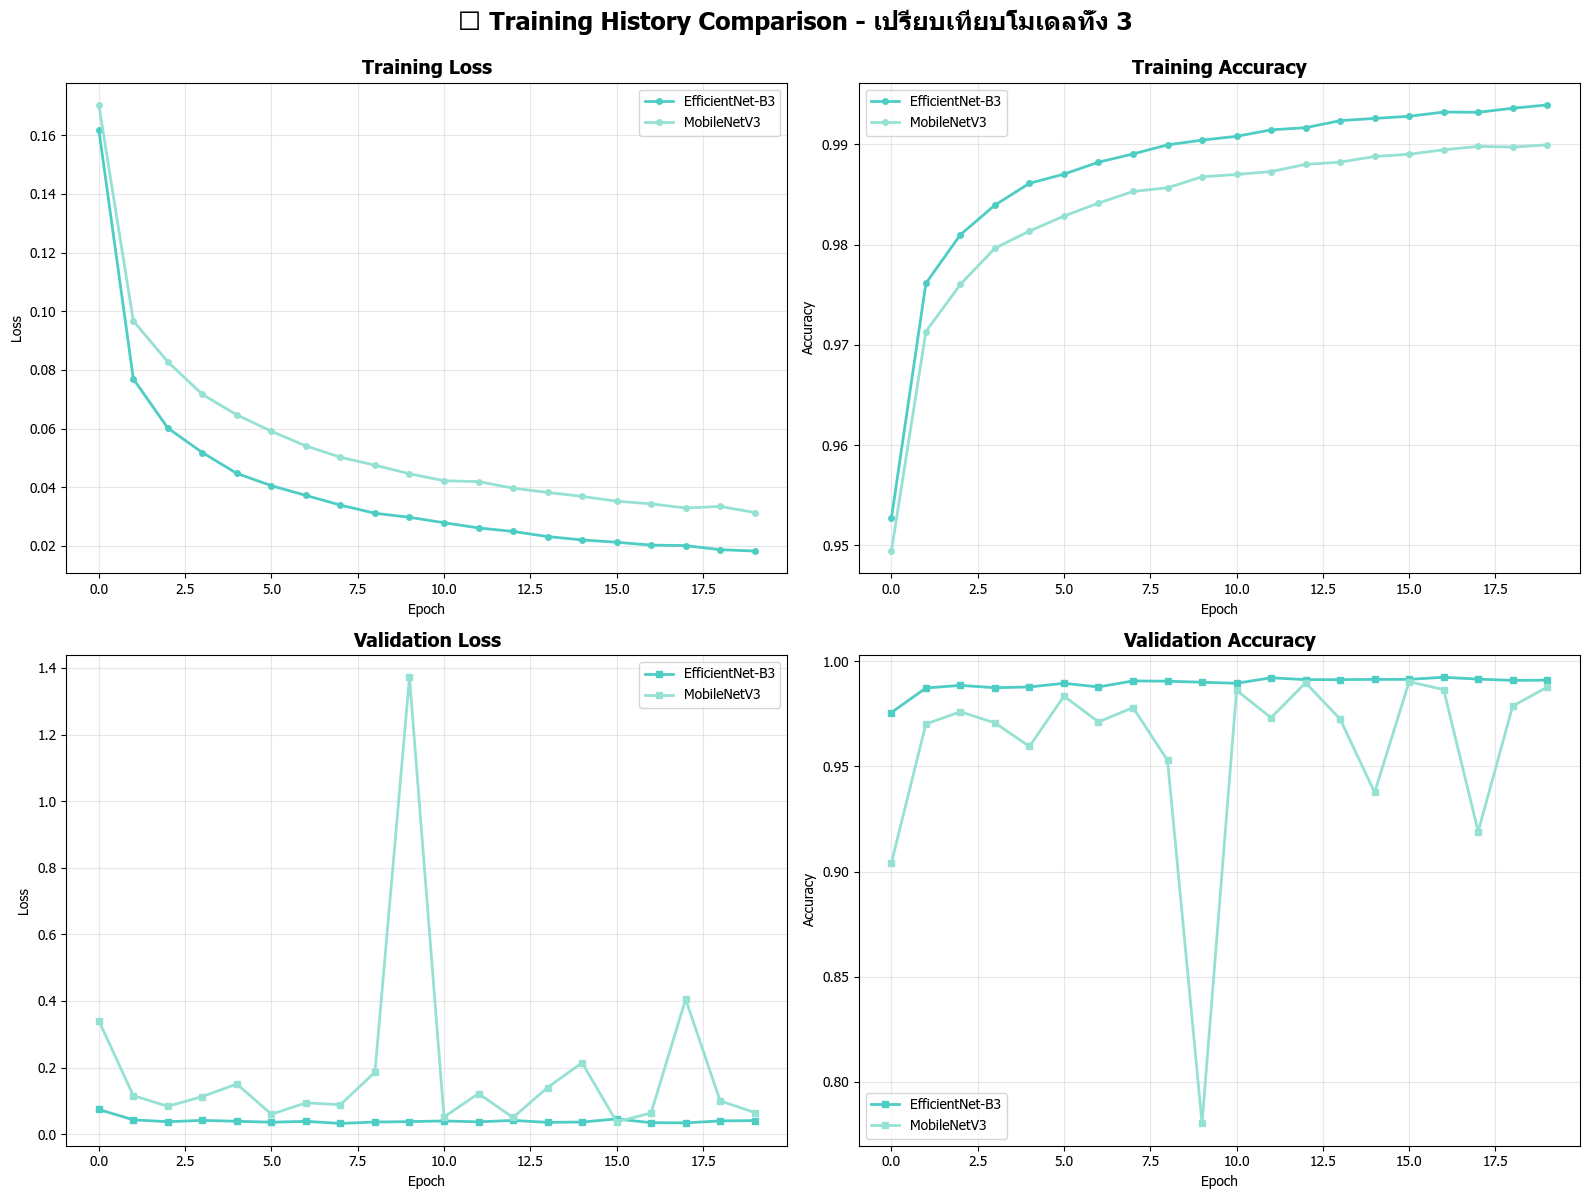

✅ บันทึกกราฟเปรียบเทียบ: training_comparison.png


In [11]:
# Plot Training - เปรียบเทียบทั้ง 3 โมเดล

# ตรวจสอบว่ามี all_results หรือไม่
if 'all_results' not in globals() or not all_results:
    print("⚠️ ไม่พบข้อมูล all_results")
    print("📂 พยายามโหลดข้อมูลจากไฟล์ที่บันทึกไว้...")
    
    all_results = {}
    for model_name in ['resnet50', 'efficientnet_b3', 'mobilenet_v3']:
        history_path = os.path.join(OUTPUT_DIRS[model_name], 'training_history.json')
        if os.path.exists(history_path):
            with open(history_path, 'r') as f:
                all_results[model_name] = json.load(f)
            print(f"✅ โหลด {model_name} history สำเร็จ")
        else:
            print(f"❌ ไม่พบไฟล์: {history_path}")
    
    if not all_results:
        print("\n❌ ไม่พบข้อมูล Training History")
        print("กรุณาฝึกโมเดลก่อน โดยรันเซลล์:")
        print("  - เซลล์ที่ 15 (Train Individual Model) หรือ")
        print("  - เซลล์ที่ 17 (Train All Models)")
        raise ValueError("ไม่พบข้อมูล all_results และไม่สามารถโหลดจากไฟล์ได้")
    else:
        print(f"\n✅ โหลดข้อมูลสำเร็จ {len(all_results)} โมเดล")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('📊 Training History Comparison - เปรียบเทียบโมเดลทั้ง 3',
             fontsize=18, weight='bold', y=0.995)

colors = {'resnet50': '#FF6B6B', 'efficientnet_b3': '#4ECDC4', 'mobilenet_v3': '#95E1D3'}
model_labels = {'resnet50': 'ResNet50', 'efficientnet_b3': 'EfficientNet-B3', 'mobilenet_v3': 'MobileNetV3'}

# Train Loss
for model_name, history in all_results.items():
    axes[0, 0].plot(history['train_loss'], label=model_labels[model_name],
                    color=colors[model_name], linewidth=2, marker='o', markersize=4)
axes[0, 0].set_title('Training Loss', fontsize=14, weight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Train Accuracy
for model_name, history in all_results.items():
    axes[0, 1].plot(history['train_acc'], label=model_labels[model_name],
                    color=colors[model_name], linewidth=2, marker='o', markersize=4)
axes[0, 1].set_title('Training Accuracy', fontsize=14, weight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Validation Loss
for model_name, history in all_results.items():
    axes[1, 0].plot(history['val_loss'], label=model_labels[model_name],
                    color=colors[model_name], linewidth=2, marker='s', markersize=4)
axes[1, 0].set_title('Validation Loss', fontsize=14, weight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Validation Accuracy
for model_name, history in all_results.items():
    axes[1, 1].plot(history['val_acc'], label=model_labels[model_name],
                    color=colors[model_name], linewidth=2, marker='s', markersize=4)
axes[1, 1].set_title('Validation Accuracy', fontsize=14, weight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ บันทึกกราฟเปรียบเทียบ: training_comparison.png")

## 🧪 Evaluation Function

In [12]:
def evaluate_model(model, test_loader, class_names, model_name):
    """
    ประเมินผลโมเดลบน Test Set
    """
    model.eval()
    all_preds = []
    all_labels = []

    print(f"\n🧪 กำลังประเมินโมเดล: {model_name}")

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Testing'):
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # คำนวณความแม่นยำ
    accuracy = accuracy_score(all_labels, all_preds)

    # หาคลาสที่ปรากฏใน test set
    unique_labels = sorted(list(set(all_labels)))

    # สร้าง Classification Report (ใช้เฉพาะคลาสที่มีใน test set)
    report = classification_report(all_labels, all_preds,
                                   labels=unique_labels,
                                   target_names=[class_names[i] for i in unique_labels],
                                   output_dict=True,
                                   zero_division=0)

    print(f"\n✅ {model_name} - Test Accuracy: {accuracy*100:.2f}%")
    print(f"📊 คลาสที่พบใน Test Set: {len(unique_labels)}/{len(class_names)}")

    return all_preds, all_labels, accuracy, report

print("✅ Evaluation function created")

✅ Evaluation function created


## 📊 Test All Models & Create Confusion Matrix

## 🔄 โหลดโมเดลที่ฝึกแล้ว (ถ้ามี)
ถ้าคุณฝึกโมเดลไว้แล้วและต้องการโหลดมาทดสอบ


🧪 เริ่มทดสอบโมเดล: EFFICIENTNET_B3

📂 กำลังโหลดโมเดล: outputs_efficientnet_b3\efficientnet_b3_best.pt
✅ โหลดโมเดลสำเร็จ

🧪 กำลังทดสอบบน Test Set...

🧪 กำลังประเมินโมเดล: efficientnet_b3


Testing: 100%|██████████| 252/252 [01:11<00:00,  3.55it/s]



✅ efficientnet_b3 - Test Accuracy: 98.75%
📊 คลาสที่พบใน Test Set: 72/72

📊 ผลการทดสอบ - EfficientNet-B3
✅ Test Accuracy: 98.75%
📈 Precision (Macro): 0.9867
📈 Recall (Macro): 0.9891
📈 F1-Score (Macro): 0.9877

📊 กำลังสร้าง Confusion Matrix...


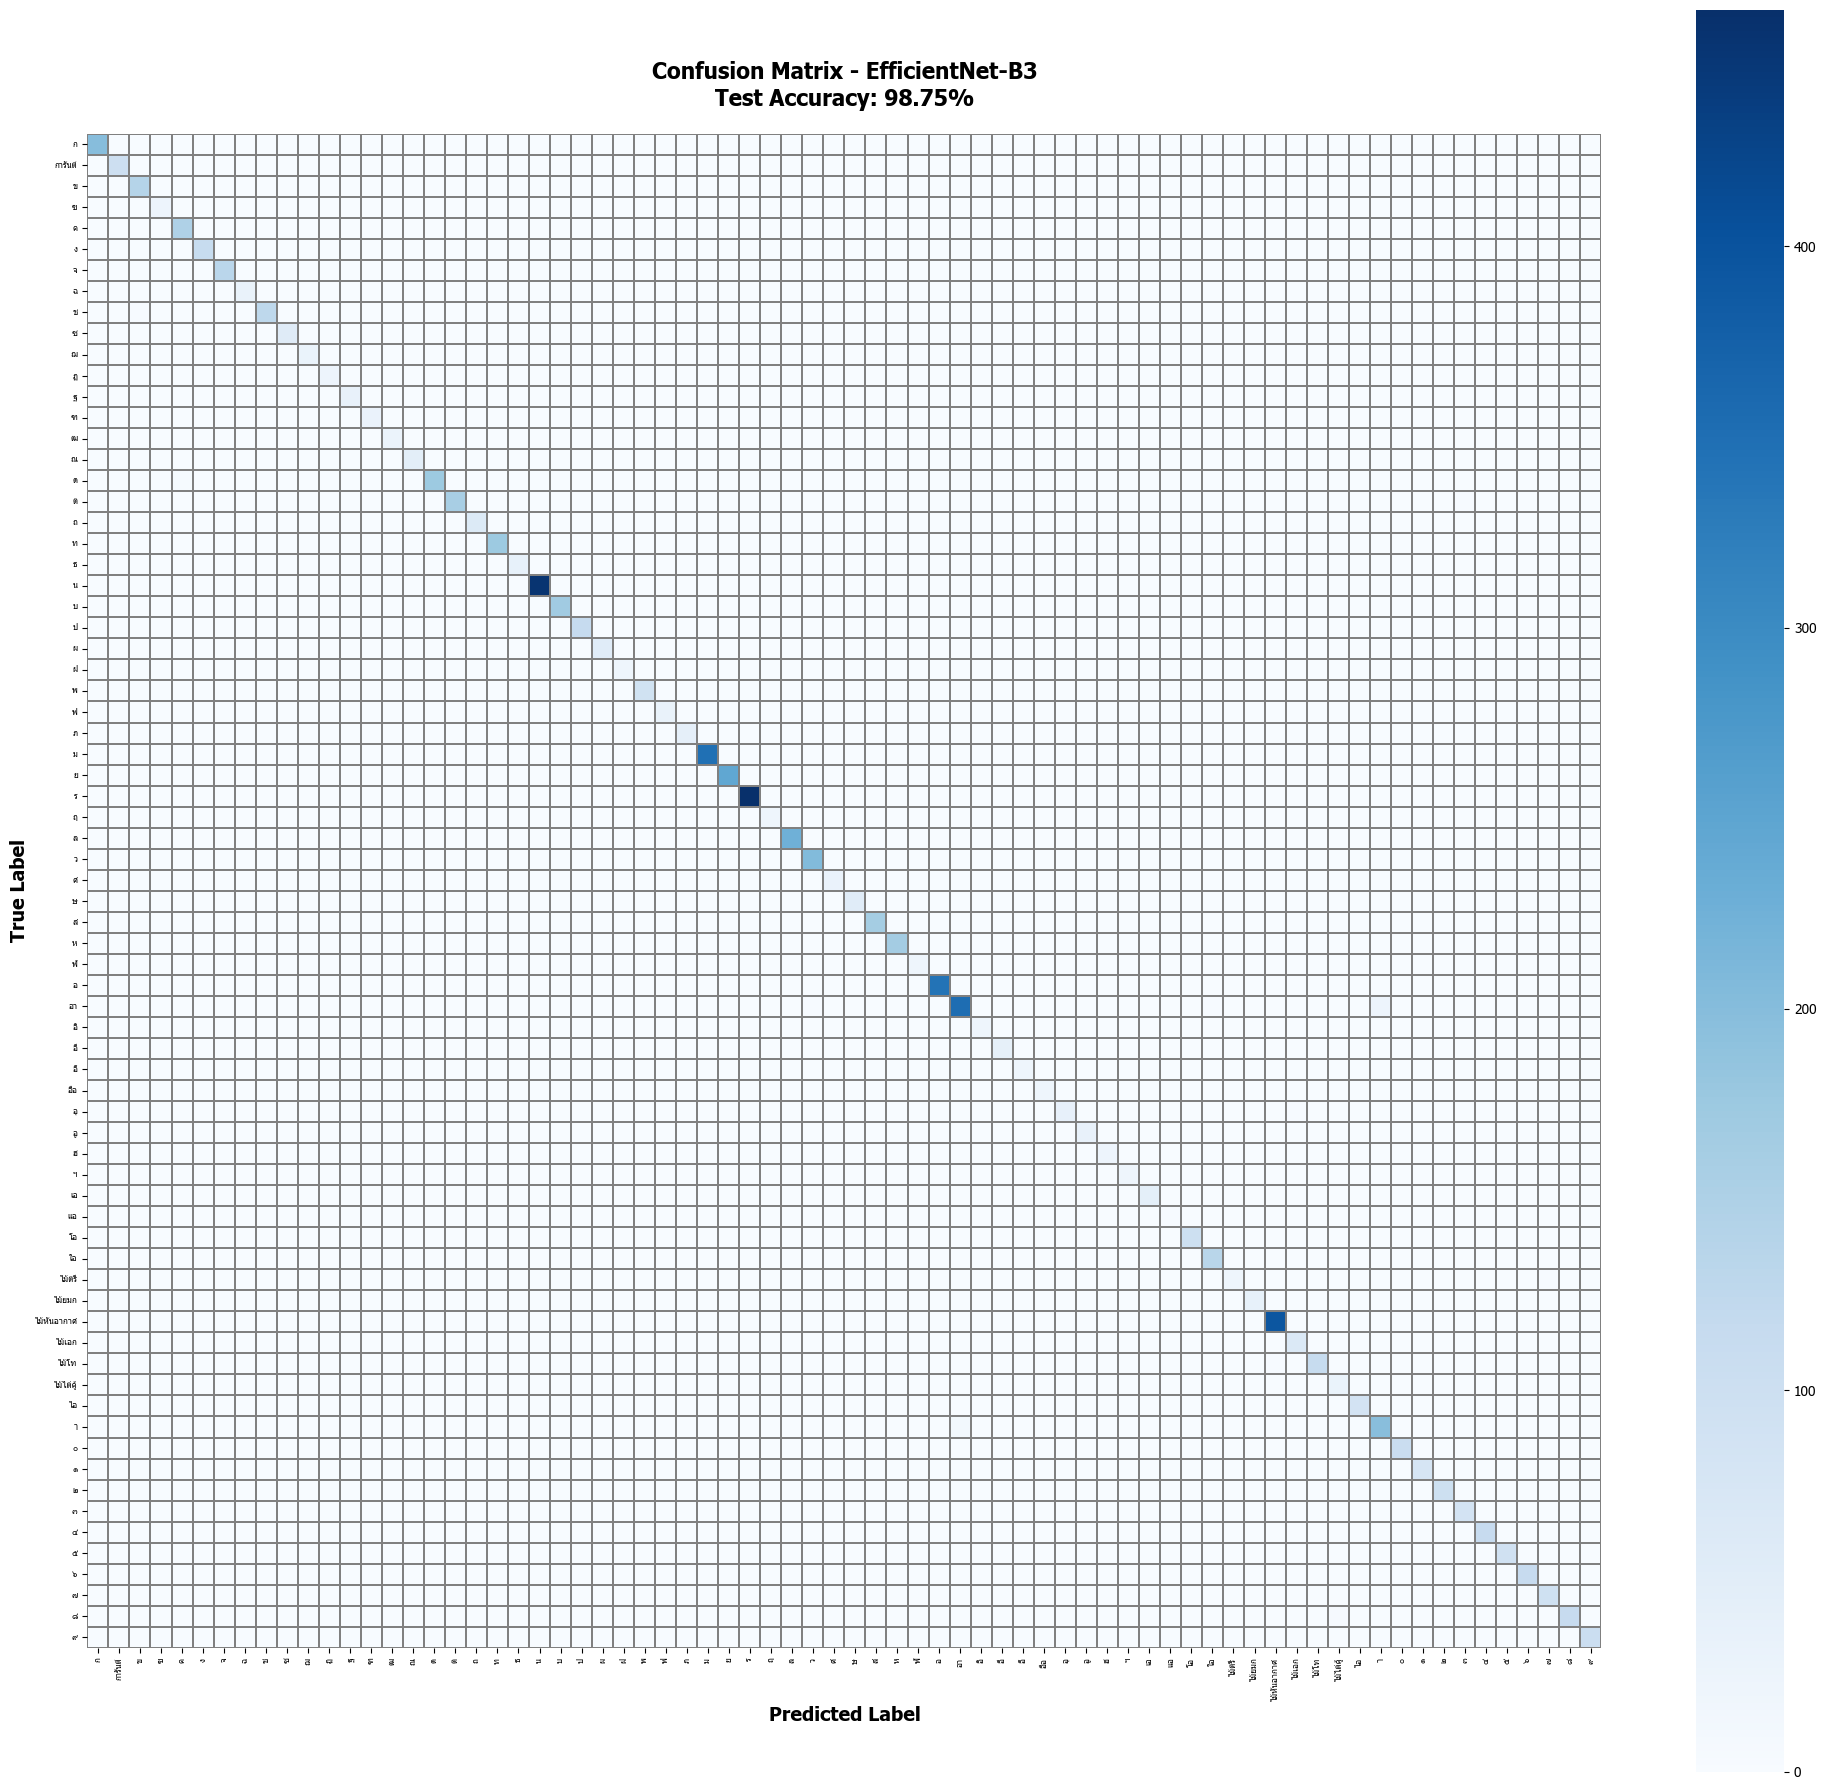


💾 บันทึก Confusion Matrix: outputs_efficientnet_b3\confusion_matrix_efficientnet_b3_test.png
💾 บันทึก Classification Report: outputs_efficientnet_b3\classification_report_efficientnet_b3.json

⚠️ Top 5 คลาสที่ทำนายผิดมากที่สุด:
1. 'ไม้ไต่คู้' - F1-Score: 0.8955 (Support: 31 samples)
2. 'ไม้ตรี' - F1-Score: 0.9091 (Support: 23 samples)
3. 'ๅ' - F1-Score: 0.9163 (Support: 209 samples)
4. 'อา' - F1-Score: 0.9439 (Support: 383 samples)
5. '๗' - F1-Score: 0.9592 (Support: 96 samples)

✅ การทดสอบ EfficientNet-B3 เสร็จสิ้น


In [13]:
# ========================================
# 🎯 ทดสอบโมเดลแยกทีละตัว
# ========================================
# เลือกโมเดลที่ต้องการทดสอบ
# เปลี่ยน test_model_name เป็น:
# - 'resnet50'
# - 'efficientnet_b3'
# - 'mobilenet_v3'

TEST_INDIVIDUAL = True  # เปลี่ยนเป็น True เพื่อทดสอบโมเดลเดียว
test_model_name = 'efficientnet_b3'  # 👈 เลือกโมเดลที่ต้องการทดสอบ

if TEST_INDIVIDUAL:
    print(f"\n{'='*70}")
    print(f"🧪 เริ่มทดสอบโมเดล: {test_model_name.upper()}")
    print(f"{'='*70}\n")

    # ตรวจสอบและกำหนดค่าตัวแปรที่จำเป็น
    if 'OUTPUT_DIRS' not in globals():
        OUTPUT_DIRS = {
            'resnet50': 'outputs_resnet50',
            'efficientnet_b3': 'outputs_efficientnet_b3',
            'mobilenet_v3': 'outputs_mobilenet_v3'
        }
        print("⚙️ กำหนดค่า OUTPUT_DIRS")

    if 'model_labels' not in globals():
        model_labels = {
            'resnet50': 'ResNet50',
            'efficientnet_b3': 'EfficientNet-B3',
            'mobilenet_v3': 'MobileNetV3-Large'
        }
        print("⚙️ กำหนดค่า model_labels")

    if 'DEVICE' not in globals():
        DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"⚙️ กำหนดค่า DEVICE: {DEVICE}")

    # ตรวจสอบว่ามี Dataset หรือไม่
    if 'num_classes' not in globals() or 'class_names' not in globals() or 'test_loader' not in globals():
        print("\n❌ ไม่พบ Dataset!")
        print("⚠️ กรุณารันเซลล์ที่ 9 (Load Dataset & DataLoader) ก่อน")
        print("⚠️ จำเป็นต้องมี: num_classes, class_names, test_loader")
    else:
        # ตรวจสอบว่ามีโมเดลที่ฝึกไว้หรือไม่
        model_path = os.path.join(OUTPUT_DIRS[test_model_name], f'{test_model_name}_best.pt')

        if not os.path.exists(model_path):
            print(f"❌ ไม่พบไฟล์โมเดล: {model_path}")
            print(f"กรุณาฝึกโมเดลก่อน หรือตรวจสอบว่าบันทึกไฟล์ถูกต้อง")
        else:
            # โหลดโมเดล
            print(f"📂 กำลังโหลดโมเดล: {model_path}")

            # สร้างโมเดลตามชื่อ
            if test_model_name == 'resnet50':
                model_to_test = models.resnet50(weights=None)
                # แก้ไข Conv Layer แรกให้รับ 1 channel (Grayscale)
                model_to_test.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
                model_to_test.fc = torch.nn.Linear(model_to_test.fc.in_features, num_classes)
            elif test_model_name == 'efficientnet_b3':
                model_to_test = models.efficientnet_b3(weights=None)
                
                # แก้ไข Conv Layer แรกให้รับ 1 channel (Grayscale) เพื่อให้ตรงกับโมเดลที่บันทึกไว้
                original_conv = model_to_test.features[0][0]
                model_to_test.features[0][0] = torch.nn.Conv2d(
                    in_channels=1, 
                    out_channels=original_conv.out_channels, 
                    kernel_size=original_conv.kernel_size, 
                    stride=original_conv.stride, 
                    padding=original_conv.padding, 
                    bias=False
                )
                model_to_test.classifier[1] = torch.nn.Linear(model_to_test.classifier[1].in_features, num_classes)
            elif test_model_name == 'mobilenet_v3':
                model_to_test = models.mobilenet_v3_large(weights=None)
                # แก้ไข Conv Layer แรกให้รับ 1 channel (Grayscale)
                original_conv = model_to_test.features[0][0]
                model_to_test.features[0][0] = torch.nn.Conv2d(
                    in_channels=1, 
                    out_channels=original_conv.out_channels, 
                    kernel_size=original_conv.kernel_size, 
                    stride=original_conv.stride, 
                    padding=original_conv.padding, 
                    bias=False
                )
                model_to_test.classifier[3] = torch.nn.Linear(model_to_test.classifier[3].in_features, num_classes)
            else:
                raise ValueError(f"Unknown model: {test_model_name}")

            model_to_test.load_state_dict(torch.load(model_path))
            model_to_test = model_to_test.to(DEVICE)
            model_to_test.eval()
            print(f"✅ โหลดโมเดลสำเร็จ")

            # ประเมินผล
            print(f"\n🧪 กำลังทดสอบบน Test Set...")
            preds, labels, accuracy, report = evaluate_model(
                model_to_test, test_loader, class_names, test_model_name
            )

            # หาคลาสที่ปรากฏใน test set
            unique_labels = sorted(list(set(labels)))
            test_class_names = [class_names[i] for i in unique_labels]

            print(f"\n{'='*70}")
            print(f"📊 ผลการทดสอบ - {model_labels[test_model_name]}")
            print(f"{'='*70}")
            print(f"✅ Test Accuracy: {accuracy*100:.2f}%")
            print(f"📈 Precision (Macro): {report['macro avg']['precision']:.4f}")
            print(f"📈 Recall (Macro): {report['macro avg']['recall']:.4f}")
            print(f"📈 F1-Score (Macro): {report['macro avg']['f1-score']:.4f}")

            # สร้าง Confusion Matrix
            print(f"\n📊 กำลังสร้าง Confusion Matrix...")
            cm = confusion_matrix(labels, preds, labels=unique_labels)

            plt.figure(figsize=(20, 18))

            if len(test_class_names) > 50:
                sns.heatmap(cm, cmap='Blues', cbar=True, square=True,
                           xticklabels=test_class_names, yticklabels=test_class_names,
                           linewidths=0.1, linecolor='gray')
                plt.xticks(rotation=90, fontsize=6)
                plt.yticks(rotation=0, fontsize=6)
            else:
                sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
                           xticklabels=test_class_names, yticklabels=test_class_names,
                           linewidths=0.5, linecolor='gray')
                plt.xticks(rotation=90, fontsize=8)
                plt.yticks(rotation=0, fontsize=8)

            plt.title(f'Confusion Matrix - {model_labels[test_model_name]}\nTest Accuracy: {accuracy*100:.2f}%',
                     fontsize=16, weight='bold', pad=20)
            plt.xlabel('Predicted Label', fontsize=14, weight='bold')
            plt.ylabel('True Label', fontsize=14, weight='bold')
            plt.tight_layout()

            # บันทึก
            output_dir = OUTPUT_DIRS[test_model_name]
            cm_path = os.path.join(output_dir, f'confusion_matrix_{test_model_name}_test.png')
            plt.savefig(cm_path, dpi=300, bbox_inches='tight')
            plt.show()

            print(f"\n💾 บันทึก Confusion Matrix: {cm_path}")

            # บันทึก Classification Report
            report_path = os.path.join(output_dir, f'classification_report_{test_model_name}.json')
            with open(report_path, 'w', encoding='utf-8') as f:
                json.dump(report, f, ensure_ascii=False, indent=4)

            print(f"💾 บันทึก Classification Report: {report_path}")

            # แสดงข้อมูลคลาสที่มี accuracy ต่ำสุด 5 อันดับ
            print(f"\n{'='*70}")
            print(f"⚠️ Top 5 คลาสที่ทำนายผิดมากที่สุด:")
            print(f"{'='*70}")

            class_accuracy = []
            # ใช้เฉพาะคลาสที่อยู่ใน test set
            for class_name in test_class_names:
                if class_name in report and isinstance(report[class_name], dict) and 'f1-score' in report[class_name]:
                    class_accuracy.append({
                        'class': class_name,
                        'f1-score': report[class_name]['f1-score'],
                        'support': report[class_name]['support']
                    })

            # เรียงตาม f1-score จากน้อยไปมาก
            if class_accuracy:
                class_accuracy_sorted = sorted(class_accuracy, key=lambda x: x['f1-score'])

                for i, item in enumerate(class_accuracy_sorted[:5], 1):
                    print(f"{i}. '{item['class']}' - F1-Score: {item['f1-score']:.4f} (Support: {int(item['support'])} samples)")
            else:
                print("ไม่สามารถแสดงรายละเอียดได้")

            print(f"\n{'='*70}")
            print(f"✅ การทดสอบ {model_labels[test_model_name]} เสร็จสิ้น")
            print(f"{'='*70}")

else:
    print("ℹ️ ตั้งค่า TEST_INDIVIDUAL = True เพื่อทดสอบโมเดลเดียว")
    print("ℹ️ และเลือก test_model_name ที่ต้องการทดสอบ")


👁️ แสดงตัวอย่างการทำนาย: EFFICIENTNET_B3

📂 กำลังโหลดโมเดล...
✅ โหลดโมเดลสำเร็จ


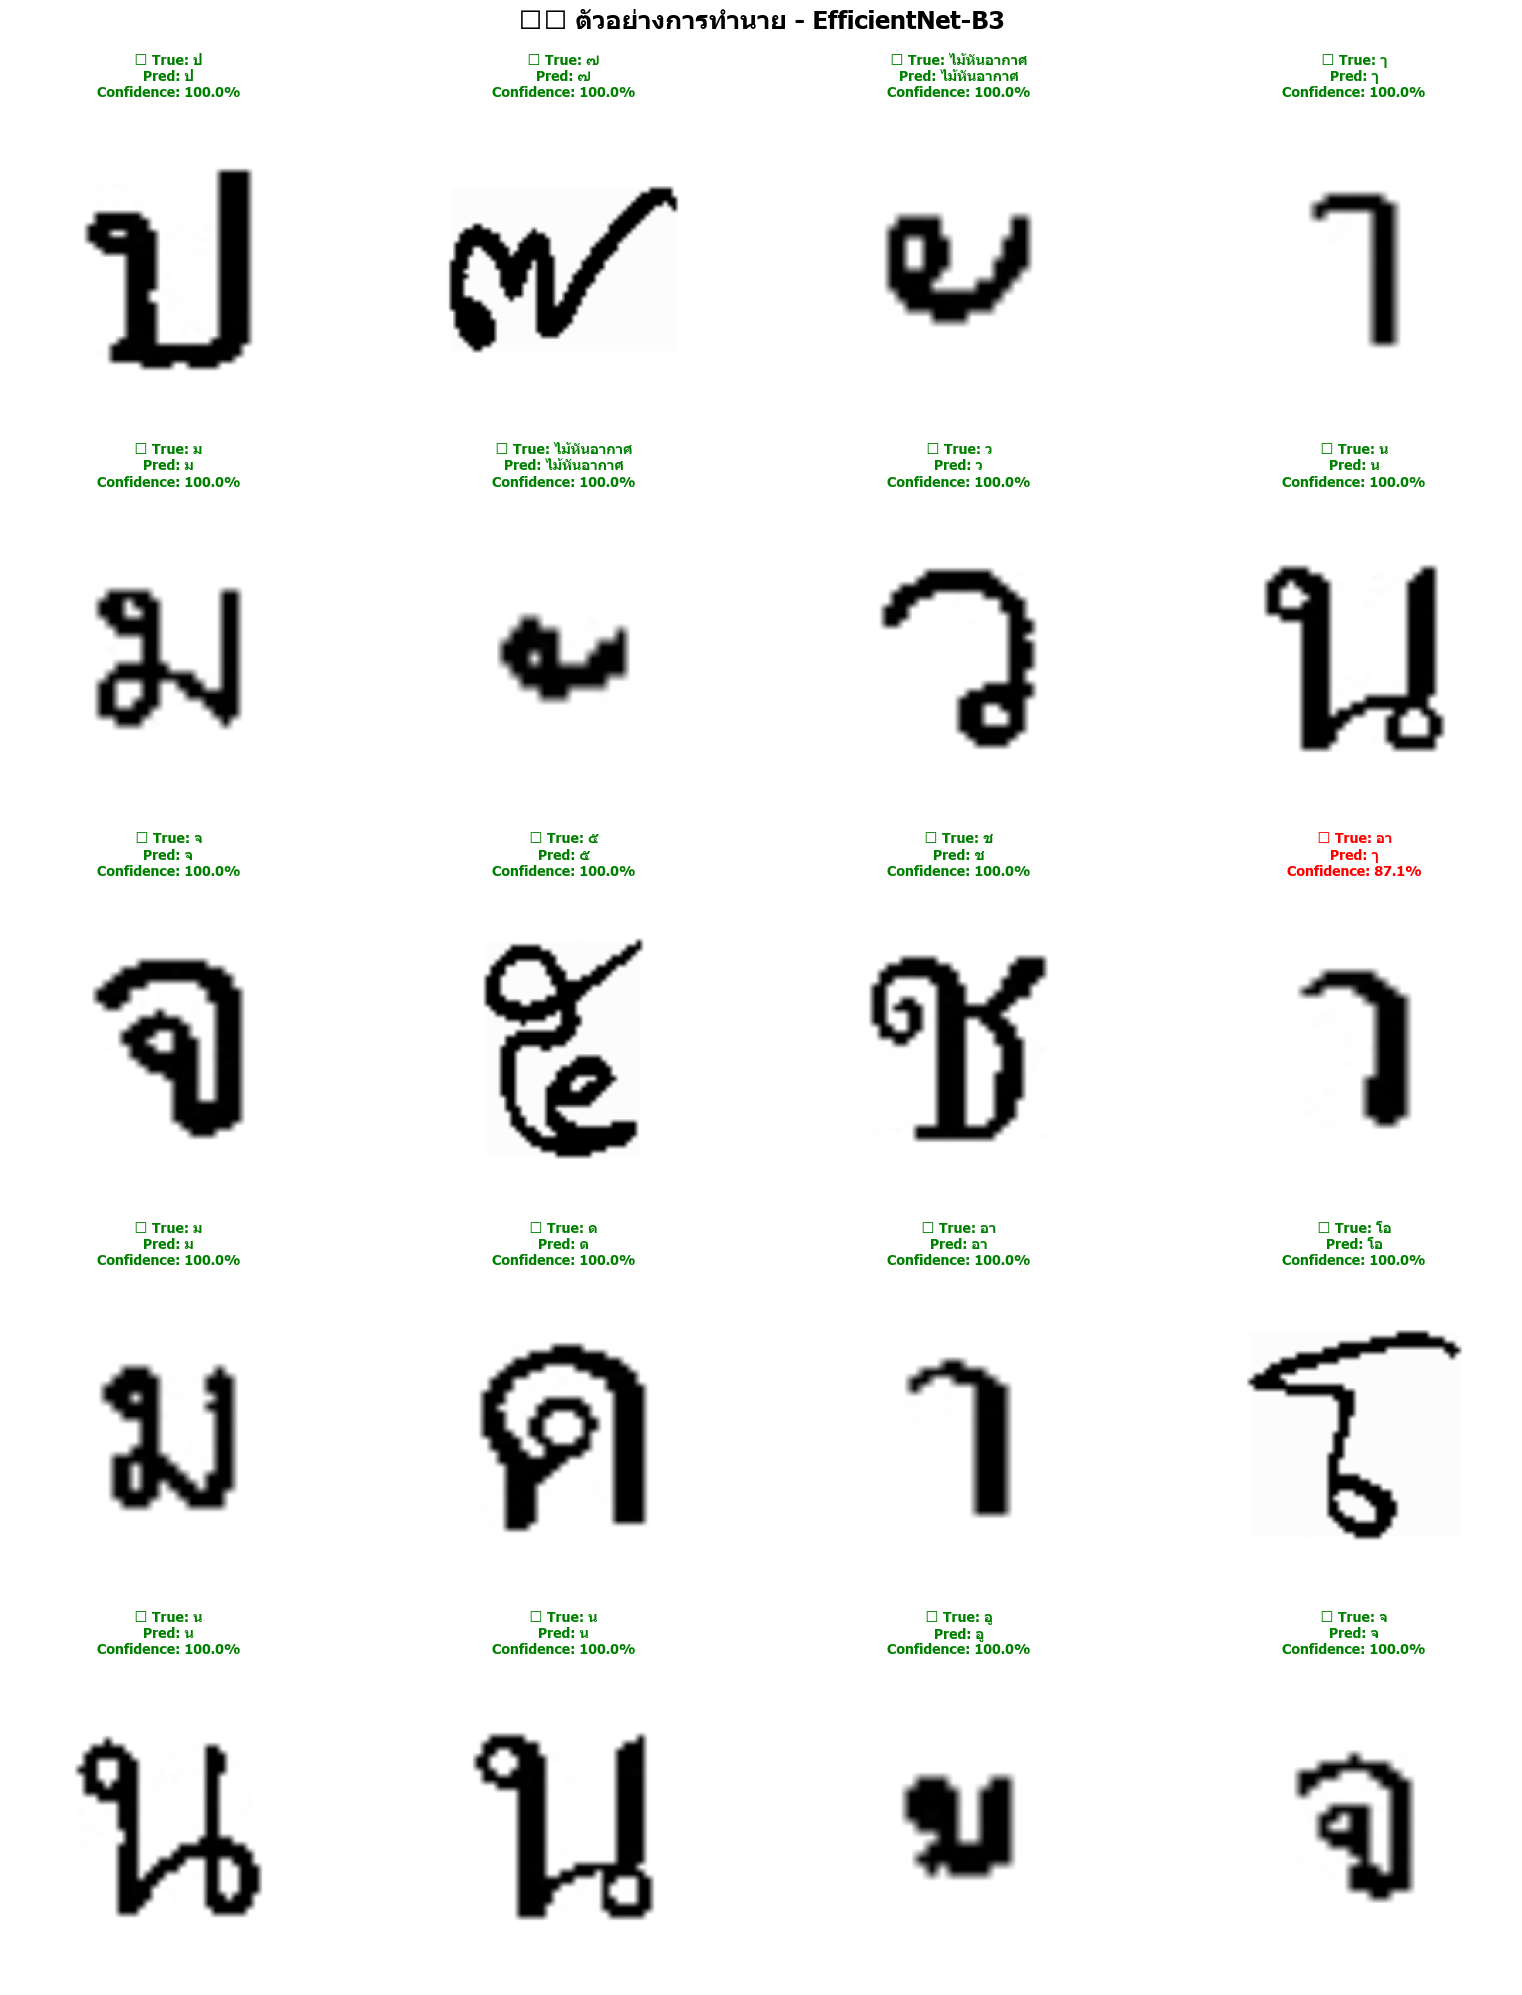


📊 สถิติจากตัวอย่าง:
  - ทำนายถูก: 19/20 (95.0%)
  - ทำนายผิด: 1/20

💾 บันทึกภาพ: outputs_efficientnet_b3\prediction_samples_efficientnet_b3.png


In [14]:
# ========================================
# 👁️ ดูตัวอย่างการทำนายจากโมเดลเดียว
# ========================================

VIEW_PREDICTIONS = True  # เปลี่ยนเป็น True เพื่อดูตัวอย่าง
view_model_name = 'efficientnet_b3'  # 👈 เลือกโมเดลที่ต้องการดู
num_samples = 20  # จำนวนภาพที่ต้องการดู

if VIEW_PREDICTIONS:
    print(f"\n{'='*70}")
    print(f"👁️ แสดงตัวอย่างการทำนาย: {view_model_name.upper()}")
    print(f"{'='*70}\n")

    # ตรวจสอบและกำหนดค่าตัวแปรที่จำเป็น
    if 'OUTPUT_DIRS' not in globals():
        OUTPUT_DIRS = {
            'resnet50': 'outputs_resnet50',
            'efficientnet_b3': 'outputs_efficientnet_b3',
            'mobilenet_v3': 'outputs_mobilenet_v3'
        }
        print("⚙️ กำหนดค่า OUTPUT_DIRS")

    if 'model_labels' not in globals():
        model_labels = {
            'resnet50': 'ResNet50',
            'efficientnet_b3': 'EfficientNet-B3',
            'mobilenet_v3': 'MobileNetV3-Large'
        }
        print("⚙️ กำหนดค่า model_labels")

    if 'DEVICE' not in globals():
        DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"⚙️ กำหนดค่า DEVICE: {DEVICE}")

    # ตรวจสอบว่ามี Dataset หรือไม่
    if 'num_classes' not in globals() or 'class_names' not in globals() or 'test_loader' not in globals():
        print("\n❌ ไม่พบ Dataset!")
        print("⚠️ กรุณารันเซลล์ที่ 9 (Load Dataset & DataLoader) ก่อน")
        print("⚠️ จำเป็นต้องมี: num_classes, class_names, test_loader")
    else:
        # ตรวจสอบว่ามีโมเดลหรือไม่
        model_path = os.path.join(OUTPUT_DIRS[view_model_name], f'{view_model_name}_best.pt')

        if not os.path.exists(model_path):
            print(f"❌ ไม่พบไฟล์โมเดล: {model_path}")
            print(f"กรุณาฝึกโมเดลก่อน")
        else:
            # โหลดโมเดล
            print(f"📂 กำลังโหลดโมเดล...")
            # Import necessary modules
            import torchvision.models as models

            # Create model based on model name
            if view_model_name == 'resnet50':
                view_model = models.resnet50(pretrained=False)
                # แก้ไข Conv Layer แรกให้รับ 1 channel (Grayscale)
                view_model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
                view_model.fc = torch.nn.Linear(view_model.fc.in_features, num_classes)
            elif view_model_name == 'efficientnet_b3':
                # สร้างโมเดลพื้นฐานขึ้นมาก่อน
                view_model = models.efficientnet_b3(pretrained=False)
                # แก้ไข Conv layer แรกให้รับ 1 channel เพื่อให้ตรงกับไฟล์ที่เซฟไว้
                original_conv = view_model.features[0][0]
                view_model.features[0][0] = torch.nn.Conv2d(
                    in_channels=1, 
                    out_channels=original_conv.out_channels, 
                    kernel_size=original_conv.kernel_size, 
                    stride=original_conv.stride, 
                    padding=original_conv.padding, 
                    bias=original_conv.bias
                )
                view_model.classifier[1] = torch.nn.Linear(view_model.classifier[1].in_features, num_classes)
            elif view_model_name == 'mobilenet_v3':
                view_model = models.mobilenet_v3_large(pretrained=False)
                # แก้ไข Conv Layer แรกให้รับ 1 channel (Grayscale)
                original_conv = view_model.features[0][0]
                view_model.features[0][0] = torch.nn.Conv2d(
                    in_channels=1, 
                    out_channels=original_conv.out_channels, 
                    kernel_size=original_conv.kernel_size, 
                    stride=original_conv.stride, 
                    padding=original_conv.padding, 
                    bias=False
                )
                view_model.classifier[3] = torch.nn.Linear(view_model.classifier[3].in_features, num_classes)

            # โหลด weights และย้ายไปยัง device
            view_model.load_state_dict(torch.load(model_path, map_location=DEVICE))
            view_model = view_model.to(DEVICE)

            print(f"✅ โหลดโมเดลสำเร็จ")

            # ดึงข้อมูลตัวอย่าง
            dataiter = iter(test_loader)
            images, labels = next(dataiter)
            images = images[:num_samples]
            labels = labels[:num_samples]

            # คำนวณจำนวน row และ column
            n_cols = 4
            n_rows = (num_samples + n_cols - 1) // n_cols

            # สร้างกราฟ
            fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows*4))
            fig.suptitle(f'👁️ ตัวอย่างการทำนาย - {model_labels[view_model_name]}',
                         fontsize=18, weight='bold', y=0.995, fontfamily='sans-serif')

            # flatten axes ถ้าเป็น 2D array
            if n_rows > 1:
                axes = axes.flatten()
            elif n_rows == 1 and n_cols > 1:
                axes = axes
            else:
                axes = [axes]

            correct_count = 0

            for idx in range(num_samples):
                # แสดงรูป
                img = images[idx].cpu()
                # Denormalize สำหรับ Grayscale (ใช้ mean=0.5, std=0.5)
                img = img * 0.5 + 0.5  # Denormalize จาก [-1, 1] กลับเป็น [0, 1]
                img = torch.clamp(img, 0, 1)
                
                # เปลี่ยนจาก (1, H, W) เป็น (H, W) สำหรับ grayscale
                if img.shape[0] == 1:
                    img_np = img.squeeze(0).numpy()
                else:
                    img_np = img.permute(1, 2, 0).numpy()

                true_label = class_names[labels[idx]]

                # ทำนาย
                view_model.eval()
                with torch.no_grad():
                    output = view_model(images[idx:idx+1].to(DEVICE))
                    probabilities = torch.nn.functional.softmax(output, dim=1)
                    confidence, pred = torch.max(probabilities, 1)
                    pred_label = class_names[pred.item()]
                    confidence_score = confidence.item() * 100

                # เลือกสี (ถูก=เขียว, ผิด=แดง)
                is_correct = pred_label == true_label
                if is_correct:
                    correct_count += 1
                    border_color = 'green'
                    status = '✅'
                else:
                    border_color = 'red'
                    status = '❌'

                # แสดงภาพ (grayscale)
                axes[idx].imshow(img_np, cmap='gray')
                axes[idx].set_title(
                    f'{status} True: {true_label}\nPred: {pred_label}\nConfidence: {confidence_score:.1f}%',
                    fontsize=10, color=border_color, weight='bold', pad=10
                )
                axes[idx].axis('off')

                # เพิ่มกรอบสี
                for spine in axes[idx].spines.values():
                    spine.set_edgecolor(border_color)
                    spine.set_linewidth(3)

            # ซ่อน axes ที่ไม่ได้ใช้
            for idx in range(num_samples, len(axes)):
                axes[idx].axis('off')

            plt.tight_layout()

            # บันทึก
            output_dir = OUTPUT_DIRS[view_model_name]
            pred_path = os.path.join(output_dir, f'prediction_samples_{view_model_name}.png')
            plt.savefig(pred_path, dpi=300, bbox_inches='tight')
            plt.show()

            # แสดงสถิติ
            accuracy = (correct_count / num_samples) * 100
            print(f"\n{'='*70}")
            print(f"📊 สถิติจากตัวอย่าง:")
            print(f"  - ทำนายถูก: {correct_count}/{num_samples} ({accuracy:.1f}%)")
            print(f"  - ทำนายผิด: {num_samples - correct_count}/{num_samples}")
            print(f"\n💾 บันทึกภาพ: {pred_path}")
            print(f"{'='*70}")

else:
    print("ℹ️ ตั้งค่า VIEW_PREDICTIONS = True เพื่อดูตัวอย่างการทำนาย")
    print("ℹ️ และเลือก view_model_name ที่ต้องการดู")


📈 วิเคราะห์โมเดล: EFFICIENTNET_B3

✅ โหลด Training History สำเร็จ


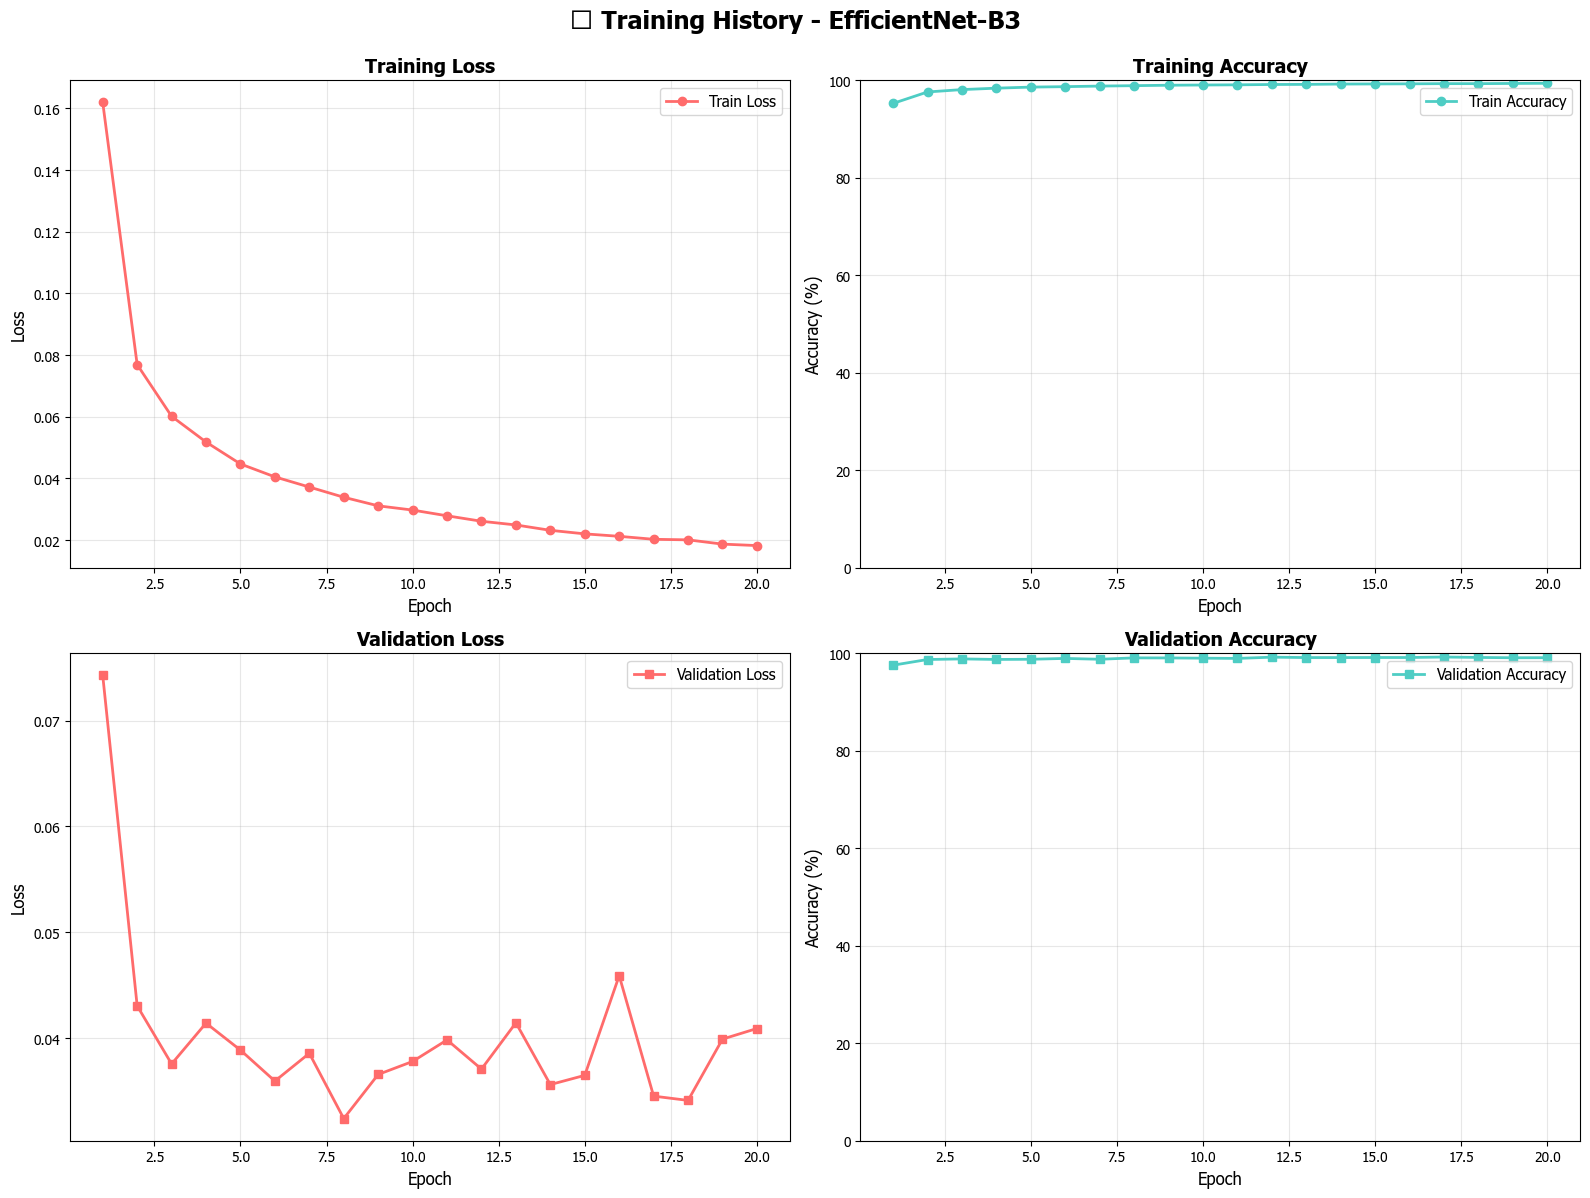


📊 สถิติการเทรน:
จำนวน Epochs: 20

🔹 Training Loss:
  - เริ่มต้น: 0.1619
  - สุดท้าย: 0.0182
  - ลดลง: 0.1437

🔹 Training Accuracy:
  - เริ่มต้น: 95.27%
  - สุดท้าย: 99.39%
  - เพิ่มขึ้น: 4.13%

🔹 Validation Loss:
  - เริ่มต้น: 0.0743
  - ต่ำสุด: 0.0324 (Epoch 8)
  - สุดท้าย: 0.0409

🔹 Validation Accuracy:
  - เริ่มต้น: 97.57%
  - สูงสุด: 99.24% (Epoch 17)
  - สุดท้าย: 99.11%

⚠️ การตรวจสอบ Overfitting:
🟢 ไม่มี Overfitting
   Train Acc: 99.39%
   Val Acc: 99.11%
   ส่วนต่าง: 0.29%

💾 บันทึกกราฟ: outputs_efficientnet_b3\training_history_efficientnet_b3.png


In [15]:
# ========================================
# 📈 วิเคราะห์รายละเอียดโมเดลเดียว
# ========================================

ANALYZE_MODEL = True  # เปลี่ยนเป็น True เพื่อวิเคราะห์
analyze_model_name = 'efficientnet_b3'  # 👈 เลือกโมเดลที่ต้องการวิเคราะห์

if ANALYZE_MODEL:
    print(f"\n{'='*70}")
    print(f"📈 วิเคราะห์โมเดล: {analyze_model_name.upper()}")
    print(f"{'='*70}\n")

    # ตรวจสอบและกำหนดค่าตัวแปรที่จำเป็น
    if 'OUTPUT_DIRS' not in globals():
        OUTPUT_DIRS = {
            'resnet50': 'outputs_resnet50',
            'efficientnet_b3': 'outputs_efficientnet_b3',
            'mobilenet_v3': 'outputs_mobilenet_v3'
        }
        print("⚙️ กำหนดค่า OUTPUT_DIRS")

    if 'model_labels' not in globals():
        model_labels = {
            'resnet50': 'ResNet50',
            'efficientnet_b3': 'EfficientNet-B3',
            'mobilenet_v3': 'MobileNetV3-Large'
        }
        print("⚙️ กำหนดค่า model_labels")

    # ตรวจสอบไฟล์ history
    history_path = os.path.join(OUTPUT_DIRS[analyze_model_name], 'training_history.json')

    if not os.path.exists(history_path):
        print(f"\n❌ ไม่พบไฟล์ history: {history_path}")
        print(f"กรุณาฝึกโมเดลก่อน")
    else:
        # โหลด history
        with open(history_path, 'r') as f:
            history = json.load(f)

        print(f"✅ โหลด Training History สำเร็จ")

        # สร้างกราฟ Training History
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle(f'📊 Training History - {model_labels[analyze_model_name]}',
                     fontsize=18, weight='bold', y=0.995)

        epochs = range(1, len(history['train_loss']) + 1)

        # Train Loss
        axes[0, 0].plot(epochs, history['train_loss'],
                       label='Train Loss', color='#FF6B6B', linewidth=2, marker='o', markersize=6)
        axes[0, 0].set_title('Training Loss', fontsize=14, weight='bold')
        axes[0, 0].set_xlabel('Epoch', fontsize=12)
        axes[0, 0].set_ylabel('Loss', fontsize=12)
        axes[0, 0].legend(fontsize=11)
        axes[0, 0].grid(True, alpha=0.3)

        # Train Accuracy
        train_acc_percent = [acc * 100 for acc in history['train_acc']]
        axes[0, 1].plot(epochs, train_acc_percent,
                       label='Train Accuracy', color='#4ECDC4', linewidth=2, marker='o', markersize=6)
        axes[0, 1].set_title('Training Accuracy', fontsize=14, weight='bold')
        axes[0, 1].set_xlabel('Epoch', fontsize=12)
        axes[0, 1].set_ylabel('Accuracy (%)', fontsize=12)
        axes[0, 1].set_ylim([0, 100])
        axes[0, 1].legend(fontsize=11)
        axes[0, 1].grid(True, alpha=0.3)

        # Validation Loss
        axes[1, 0].plot(epochs, history['val_loss'],
                       label='Validation Loss', color='#FF6B6B', linewidth=2, marker='s', markersize=6)
        axes[1, 0].set_title('Validation Loss', fontsize=14, weight='bold')
        axes[1, 0].set_xlabel('Epoch', fontsize=12)
        axes[1, 0].set_ylabel('Loss', fontsize=12)
        axes[1, 0].legend(fontsize=11)
        axes[1, 0].grid(True, alpha=0.3)

        # Validation Accuracy
        val_acc_percent = [acc * 100 for acc in history['val_acc']]
        axes[1, 1].plot(epochs, val_acc_percent,
                       label='Validation Accuracy', color='#4ECDC4', linewidth=2, marker='s', markersize=6)
        axes[1, 1].set_title('Validation Accuracy', fontsize=14, weight='bold')
        axes[1, 1].set_xlabel('Epoch', fontsize=12)
        axes[1, 1].set_ylabel('Accuracy (%)', fontsize=12)
        axes[1, 1].set_ylim([0, 100])
        axes[1, 1].legend(fontsize=11)
        axes[1, 1].grid(True, alpha=0.3)

        plt.tight_layout()

        # บันทึก
        output_dir = OUTPUT_DIRS[analyze_model_name]
        history_plot_path = os.path.join(output_dir, f'training_history_{analyze_model_name}.png')
        plt.savefig(history_plot_path, dpi=300, bbox_inches='tight')
        plt.show()

        # แสดงสถิติ
        print(f"\n{'='*70}")
        print(f"📊 สถิติการเทรน:")
        print(f"{'='*70}")
        print(f"จำนวน Epochs: {len(epochs)}")
        print(f"\n🔹 Training Loss:")
        print(f"  - เริ่มต้น: {history['train_loss'][0]:.4f}")
        print(f"  - สุดท้าย: {history['train_loss'][-1]:.4f}")
        print(f"  - ลดลง: {history['train_loss'][0] - history['train_loss'][-1]:.4f}")

        print(f"\n🔹 Training Accuracy:")
        print(f"  - เริ่มต้น: {train_acc_percent[0]:.2f}%")
        print(f"  - สุดท้าย: {train_acc_percent[-1]:.2f}%")
        print(f"  - เพิ่มขึ้น: {train_acc_percent[-1] - train_acc_percent[0]:.2f}%")

        print(f"\n🔹 Validation Loss:")
        print(f"  - เริ่มต้น: {history['val_loss'][0]:.4f}")
        print(f"  - ต่ำสุด: {min(history['val_loss']):.4f} (Epoch {history['val_loss'].index(min(history['val_loss'])) + 1})")
        print(f"  - สุดท้าย: {history['val_loss'][-1]:.4f}")

        print(f"\n🔹 Validation Accuracy:")
        print(f"  - เริ่มต้น: {val_acc_percent[0]:.2f}%")
        print(f"  - สูงสุด: {max(val_acc_percent):.2f}% (Epoch {val_acc_percent.index(max(val_acc_percent)) + 1})")
        print(f"  - สุดท้าย: {val_acc_percent[-1]:.2f}%")

        # ตรวจสอบ Overfitting
        print(f"\n{'='*70}")
        print(f"⚠️ การตรวจสอบ Overfitting:")
        print(f"{'='*70}")
        train_val_gap = train_acc_percent[-1] - val_acc_percent[-1]
        if train_val_gap > 10:
            print(f"🔴 มี Overfitting อยู่บ้าง")
            print(f"   Train Acc: {train_acc_percent[-1]:.2f}%")
            print(f"   Val Acc: {val_acc_percent[-1]:.2f}%")
            print(f"   ส่วนต่าง: {train_val_gap:.2f}%")
            print(f"\n💡 คำแนะนำ:")
            print(f"   - เพิ่ม Data Augmentation")
            print(f"   - ใช้ Dropout หรือ Regularization")
            print(f"   - ลด Learning Rate")
        elif train_val_gap > 5:
            print(f"🟡 มี Overfitting เล็กน้อย")
            print(f"   Train Acc: {train_acc_percent[-1]:.2f}%")
            print(f"   Val Acc: {val_acc_percent[-1]:.2f}%")
            print(f"   ส่วนต่าง: {train_val_gap:.2f}%")
        else:
            print(f"🟢 ไม่มี Overfitting")
            print(f"   Train Acc: {train_acc_percent[-1]:.2f}%")
            print(f"   Val Acc: {val_acc_percent[-1]:.2f}%")
            print(f"   ส่วนต่าง: {train_val_gap:.2f}%")

        print(f"\n💾 บันทึกกราฟ: {history_plot_path}")
        print(f"{'='*70}")

else:
    print("ℹ️ ตั้งค่า ANALYZE_MODEL = True เพื่อวิเคราะห์โมเดล")
    print("ℹ️ และเลือก analyze_model_name ที่ต้องการวิเคราะห์")


📊 วิเคราะห์การกระจายข้อมูล Training Data



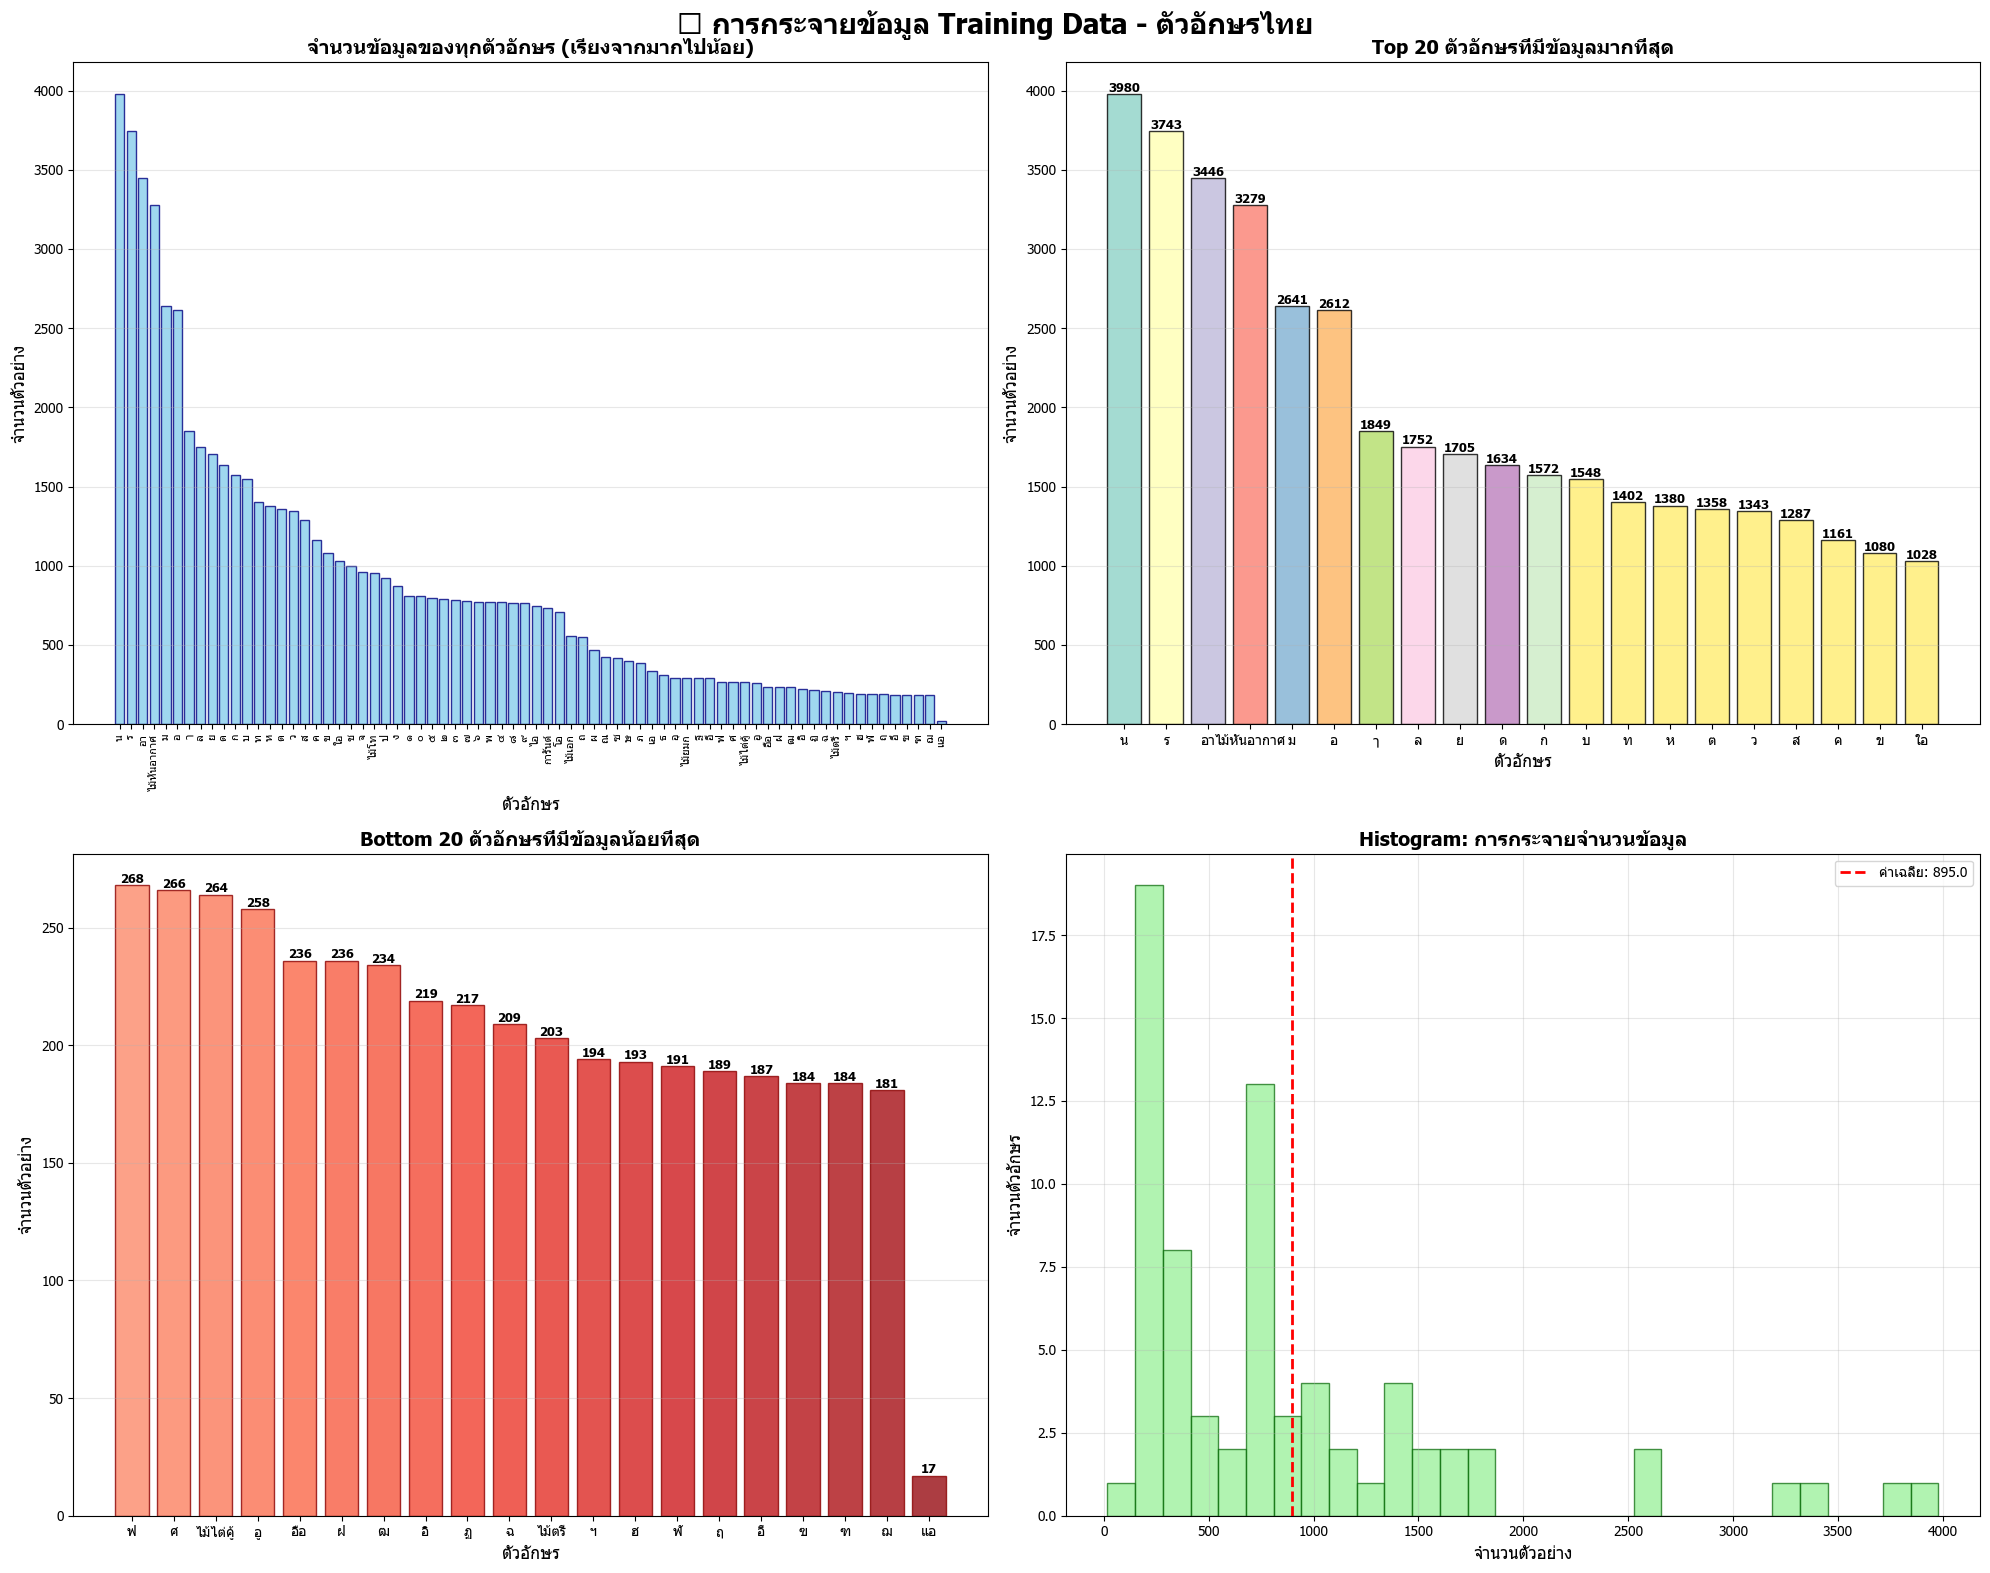


📈 สถิติการกระจายข้อมูล:
จำนวนคลาสทั้งหมด: 72
จำนวนตัวอย่างทั้งหมด: 64438 รูป
ค่าเฉลี่ย: 895.0 รูป/คลาส
ค่ามัธยฐาน: 753.0 รูป/คลาส
ค่ามากสุด: 3980 รูป ('น')
ค่าน้อยสุด: 17 รูป ('แอ')
ส่วนเบี่ยงเบนมาตรฐาน: 866.0

🔍 Top 10 ตัวอักษรที่มีข้อมูลมากที่สุด:
--------------------------------------------------
 1. 'น': 3980 รูป ( 6.2%) → 11940 รูป (หลัง aug)
 2. 'ร': 3743 รูป ( 5.8%) → 11229 รูป (หลัง aug)
 3. 'อา': 3446 รูป ( 5.3%) → 10338 รูป (หลัง aug)
 4. 'ไม้หันอากาศ': 3279 รูป ( 5.1%) →  9837 รูป (หลัง aug)
 5. 'ม': 2641 รูป ( 4.1%) →  7923 รูป (หลัง aug)
 6. 'อ': 2612 รูป ( 4.1%) →  7836 รูป (หลัง aug)
 7. 'ๅ': 1849 รูป ( 2.9%) →  5547 รูป (หลัง aug)
 8. 'ล': 1752 รูป ( 2.7%) →  5256 รูป (หลัง aug)
 9. 'ย': 1705 รูป ( 2.6%) →  5115 รูป (หลัง aug)
10. 'ด': 1634 รูป ( 2.5%) →  4902 รูป (หลัง aug)

⚠️ Top 10 ตัวอักษรที่มีข้อมูลน้อยที่สุด:
--------------------------------------------------
 1. 'ไม้ตรี':  203 รูป ( 0.3%) →   609 รูป (หลัง aug)
 2. 'ฯ':  194 รูป ( 0.3%) →   582 รูป (หลัง aug)
 

In [16]:
# ========================================
# 📊 วิเคราะห์การกระจายข้อมูล Training Data
# ========================================

def analyze_training_data_distribution():
    """
    วิเคราะห์และแสดงกราฟการกระจายข้อมูลของแต่ละตัวอักษรใน Training Set
    """
    print(f"\n{'='*70}")
    print(f"📊 วิเคราะห์การกระจายข้อมูล Training Data")
    print(f"{'='*70}\n")
    
    # นับจำนวนตัวอย่างของแต่ละคลาสใน training set
    class_counts = {}
    for idx in train_indices.indices:
        _, label = base_dataset[idx]
        class_name = class_names[label]
        class_counts[class_name] = class_counts.get(class_name, 0) + 1
    
    # เรียงข้อมูลตามจำนวนจากมากไปน้อย
    sorted_counts = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)
    
    # แยกข้อมูลสำหรับการแสดงผล
    characters = [item[0] for item in sorted_counts]
    counts = [item[1] for item in sorted_counts]
    
    # สร้างกราฟขนาดใหญ่
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    fig.suptitle('📊 การกระจายข้อมูล Training Data - ตัวอักษรไทย', 
                 fontsize=20, weight='bold', y=0.98)
    
    # กราหที่ 1: แท่งกราฟทั้งหมด (เรียงจากมากไปน้อย)
    axes[0, 0].bar(range(len(characters)), counts, color='skyblue', alpha=0.8, edgecolor='navy')
    axes[0, 0].set_title('จำนวนข้อมูลของทุกตัวอักษร (เรียงจากมากไปน้อย)', fontsize=14, weight='bold')
    axes[0, 0].set_xlabel('ตัวอักษร', fontsize=12)
    axes[0, 0].set_ylabel('จำนวนตัวอย่าง', fontsize=12)
    axes[0, 0].tick_params(axis='x', rotation=90, labelsize=8)
    axes[0, 0].set_xticks(range(len(characters)))
    axes[0, 0].set_xticklabels(characters)
    axes[0, 0].grid(True, alpha=0.3, axis='y')
    
    # กราฟที่ 2: Top 20 ตัวอักษรที่มีข้อมูลมากที่สุด
    top_20_chars = characters[:20]
    top_20_counts = counts[:20]
    colors_top = plt.cm.Set3(range(20))
    
    bars = axes[0, 1].bar(range(20), top_20_counts, color=colors_top, alpha=0.8, edgecolor='black')
    axes[0, 1].set_title('Top 20 ตัวอักษรที่มีข้อมูลมากที่สุด', fontsize=14, weight='bold')
    axes[0, 1].set_xlabel('ตัวอักษร', fontsize=12)
    axes[0, 1].set_ylabel('จำนวนตัวอย่าง', fontsize=12)
    axes[0, 1].set_xticks(range(20))
    axes[0, 1].set_xticklabels(top_20_chars, fontsize=10)
    axes[0, 1].grid(True, alpha=0.3, axis='y')
    
    # เพิ่มป้ายกำกับจำนวนบนแท่งกราฟ
    for i, (bar, count) in enumerate(zip(bars, top_20_counts)):
        axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                       str(count), ha='center', va='bottom', fontsize=9, weight='bold')
    
    # กราฟที่ 3: Bottom 20 ตัวอักษรที่มีข้อมูลน้อยที่สุด
    bottom_20_chars = characters[-20:]
    bottom_20_counts = counts[-20:]
    colors_bottom = plt.cm.Reds(np.linspace(0.4, 0.9, 20))
    
    bars_bottom = axes[1, 0].bar(range(20), bottom_20_counts, color=colors_bottom, alpha=0.8, edgecolor='darkred')
    axes[1, 0].set_title('Bottom 20 ตัวอักษรที่มีข้อมูลน้อยที่สุด', fontsize=14, weight='bold')
    axes[1, 0].set_xlabel('ตัวอักษร', fontsize=12)
    axes[1, 0].set_ylabel('จำนวนตัวอย่าง', fontsize=12)
    axes[1, 0].set_xticks(range(20))
    axes[1, 0].set_xticklabels(bottom_20_chars, fontsize=10)
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    
    # เพิ่มป้ายกำกับจำนวนบนแท่งกราฟ
    for i, (bar, count) in enumerate(zip(bars_bottom, bottom_20_counts)):
        axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                       str(count), ha='center', va='bottom', fontsize=9, weight='bold')
    
    # กราฟที่ 4: Histogram แสดงการกระจาย
    axes[1, 1].hist(counts, bins=30, color='lightgreen', alpha=0.7, edgecolor='darkgreen')
    axes[1, 1].set_title('Histogram: การกระจายจำนวนข้อมูล', fontsize=14, weight='bold')
    axes[1, 1].set_xlabel('จำนวนตัวอย่าง', fontsize=12)
    axes[1, 1].set_ylabel('จำนวนตัวอักษร', fontsize=12)
    axes[1, 1].grid(True, alpha=0.3)
    
    # เพิ่มเส้นแสดงค่าเฉลี่ย
    mean_count = np.mean(counts)
    axes[1, 1].axvline(mean_count, color='red', linestyle='--', linewidth=2, 
                      label=f'ค่าเฉลี่ย: {mean_count:.1f}')
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.savefig('training_data_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # แสดงสถิติโดยละเอียด
    print(f"\n{'='*70}")
    print(f"📈 สถิติการกระจายข้อมูล:")
    print(f"{'='*70}")
    print(f"จำนวนคลาสทั้งหมด: {len(class_counts)}")
    print(f"จำนวนตัวอย่างทั้งหมด: {sum(counts)} รูป")
    print(f"ค่าเฉลี่ย: {np.mean(counts):.1f} รูป/คลาส")
    print(f"ค่ามัธยฐาน: {np.median(counts):.1f} รูป/คลาส")
    print(f"ค่ามากสุด: {max(counts)} รูป ('{characters[0]}')")
    print(f"ค่าน้อยสุด: {min(counts)} รูป ('{characters[-1]}')")
    print(f"ส่วนเบี่ยงเบนมาตรฐาน: {np.std(counts):.1f}")
    
    print(f"\n🔍 Top 10 ตัวอักษรที่มีข้อมูลมากที่สุด:")
    print("-" * 50)
    for i, (char, count) in enumerate(sorted_counts[:10], 1):
        percentage = (count / sum(counts)) * 100
        augmented_count = count * 3  # หลัง Triple Augmentation
        print(f"{i:2d}. '{char}': {count:4d} รูป ({percentage:4.1f}%) → {augmented_count:5d} รูป (หลัง aug)")
    
    print(f"\n⚠️ Top 10 ตัวอักษรที่มีข้อมูลน้อยที่สุด:")
    print("-" * 50)
    for i, (char, count) in enumerate(sorted_counts[-10:], 1):
        percentage = (count / sum(counts)) * 100
        augmented_count = count * 3  # หลัง Triple Augmentation
        print(f"{i:2d}. '{char}': {count:4d} รูป ({percentage:4.1f}%) → {augmented_count:5d} รูป (หลัง aug)")
    
    # วิเคราะห์ Class Imbalance
    print(f"\n{'='*70}")
    print(f"⚖️ การวิเคราะห์ Class Imbalance:")
    print(f"{'='*70}")
    
    max_count = max(counts)
    min_count = min(counts)
    imbalance_ratio = max_count / min_count
    
    print(f"อัตราส่วน Class Imbalance: {imbalance_ratio:.1f}:1")
    
    if imbalance_ratio > 100:
        print(f"🔴 มี Class Imbalance สูงมาก (อัตราส่วน > 100:1)")
        print(f"💡 คำแนะนำ:")
        print(f"   - ใช้ Weighted Loss Function")
        print(f"   - เพิ่ม Data Augmentation สำหรับคลาสที่มีข้อมูลน้อย")
        print(f"   - ใช้ SMOTE หรือ Oversampling")
    elif imbalance_ratio > 50:
        print(f"🟡 มี Class Imbalance ปานกลาง (อัตราส่วน > 50:1)")
        print(f"💡 คำแนะนำ:")
        print(f"   - ใช้ Balanced Sampling")
        print(f"   - เพิ่ม Augmentation ให้คลาสที่มีข้อมูลน้อย")
    elif imbalance_ratio > 10:
        print(f"🟠 มี Class Imbalance เล็กน้อย (อัตราส่วน > 10:1)")
        print(f"💡 Triple Augmentation จะช่วยลดปัญหานี้ได้")
    else:
        print(f"🟢 Class Balance ดี (อัตราส่วน < 10:1)")
    
    # คำนวณข้อมูลหลัง Triple Augmentation
    total_after_aug = sum(counts) * 3
    print(f"\n📊 ข้อมูลหลัง Triple Augmentation:")
    print(f"  - จำนวนตัวอย่างเดิม: {sum(counts):,} รูป")
    print(f"  - จำนวนหลัง Augmentation: {total_after_aug:,} รูป (3x)")
    print(f"  - ช่วยลด Class Imbalance โดยเพิ่มข้อมูลให้ทุกคลาสเท่ากัน")
    
    return class_counts, sorted_counts

# เรียกใช้ฟังก์ชันวิเคราะห์
if 'train_indices' in globals() and 'base_dataset' in globals() and 'class_names' in globals():
    class_counts, sorted_counts = analyze_training_data_distribution()
    print(f"\n💾 บันทึกกราฟ: training_data_distribution.png")
else:
    print("❌ ไม่พบข้อมูลที่จำเป็น กรุณารันเซลล์การโหลดข้อมูลก่อน")

In [ ]:
import torch
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
import json

def test_single_image(image_path, device='cuda'):
    # Fixed paths for EfficientNet-B3
    model_path = 'outputs_efficientnet_b3/efficientnet_b3_best.pt'
    class_to_idx_path = 'outputs_efficientnet_b3/class_to_idx.json'
    
    # Load the model
    model = torch.load(model_path)
    model.eval()
    model = model.to(device)
    
    # Load class mapping
    with open(class_to_idx_path, 'r', encoding='utf-8') as f:
        class_to_idx = json.load(f)
    idx_to_class = {v: k for k, v in class_to_idx.items()}
    
    # Prepare image transforms
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Load and transform image
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image)
    input_batch = input_tensor.unsqueeze(0).to(device)
    
    # Make prediction
    with torch.no_grad():
        output = model(input_batch)
        probabilities = torch.nn.functional.softmax(output[0], dim=0)
        predicted_idx = output.argmax(1).item()
        predicted_class = idx_to_class[predicted_idx]
        confidence = probabilities[predicted_idx].item()
    
    # Display results
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title('Input Image')
    
    plt.subplot(1, 2, 2)
    plt.text(0.5, 0.5, f'Predicted: {predicted_class}\nConfidence: {confidence:.2%}',
             horizontalalignment='center',
             verticalalignment='center',
             fontsize=12)
    plt.axis('off')
    plt.show()

# Select image to test using file dialog
from tkinter import filedialog
import tkinter as tk

root = tk.Tk()
root.withdraw()  # Hide the main window

print("Please select an image to test")
image_path = filedialog.askopenfilename(
    title="Select Image File",
    filetypes=[("Image Files", "*.png *.jpg *.jpeg")],
    initialdir="Data_text"
)

if image_path:
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    test_single_image(image_path, device)
else:
    print("No image selected.")

Please select a model file (.pt)
